# Notebook 1: Parameter sweeps 

This is a jupyter notebook to give additional information about exploring some of the parameters of our agent-based model for the manuscript: "An agent-based model of the Foraging Ascomycete Hypothesis." The model is coded in python3, using the [Mesa package](https://mesa.readthedocs.io/en/master/).  


<a id='contents'></a>
## contents

[Setup and model defaults](#setup) 

### Non-viaphyte fungi

[Survival of the...only? dispersal of one fungus.](#onefungus)  

[Changing initial abundances of wood](#initialwood)  

[Effect of wood deposition](#deposition)  

[Basic competition experiments](#basiccomp)

## Viaphyte fungi

[Viaphyte survival](#Endosurv)

[Effect of wood deposition on viaphytes](#endo_newwood)

## Non-viaphyte vs. Viaphyte fungi

[Viaphyte competition experiments](#endocompetition)

[Effects of Endophyte loss](#endoloss)

## Deforestation

[100-Step control run](#control)

[Deforestation](#deforestation)  
*    [Single thin event](#deforestation)
*    [Serial thinning](#serialthin)
*    [Forest fragmentation](#fragment)

<a id='setup'></a>
## Setup and model defaults

In [35]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import thomasprocess as tp
import  plotparsers as pr

%matplotlib inline

## Setup and model defaults

Many of these are set using our notebooks for calibrating dispersal and placement of agents, [notebook 2](https://nbviewer.jupyter.org/github/danchurch/FA_ABM/blob/master/calibratingDispersal.ipynb#realData) and [notebook 3](https://nbviewer.jupyter.org/github/danchurch/FA_ABM/blob/master/calibratingForest.ipynb#realforest).

Note: in the original scripts of the model, we labeled viaphytic fungi as "endophyte competent" or "EC+", and non-viaphytic fungal agents as "endophyte competent" or "EC-", so this language is used at various points throughout this documentation. 

The parameters not used for calibration to our study site are here explored using parameter sweeps. The various simulations to follow vary one or a few of these at a time:

parameter | level | explanation
---|---|---
endophytism | True | allow endophyte life style in model run
ws | 30 | initial total energy of wood agents on the landscape
endodisp|2.0 | dispersal of endos
decompdisp|10.0 | dispersal of decomps
leafdisp | 4.0 | how well do leaves disperse
leaffall | 1 | how frequently do leaves disperse
numdecomp|1 | initial number of decomposers
numendo|1   | initial number of endos
endoloss|0.05   | rate of loss of endophyte infect per step
newwood | 15 | total energy added in new logs each step
woodfreq | 1 | how often to put new logs onto the landscape
width | 100 | grid dimensions only one (squares only)
kappa | 0.03 | average rate of parent tree clusters per unit distance
sigma | 3.0 | variance of child tree clusters +/- spread of child clusters
mu | 2.2 | average rate of child tree clusters per unit distance
nuke | False | make landscape but no agents


[back to contents](#contents)

<a id='onefungus'></a>

## Survival of the...only?

For our first parameter sweep, let's see what it takes to get established as a decomposer fungus new to an area that has recently been subject to nasty storm, with lots of wind-throw. This could represent a little bit of an ecological disturbance, blowing in fungal spores from far-away and a lot of fresh wood, with reduced loads of decomposer fungi on them. 

To model this, we keep the [model defaults](#setup) of a fair amount of initial wood present on the landscape (ws = 30), and then a steady, lower rate of wood deposition from this point on. Our single species of fungus is not viaphytic.  We'll sweep the coefficient of dispersal for this fungus, from 1 to 15. Our aciss scripts look like this, with the decompdist incremented up to 15:



In [ ]:
mpiexec -n 10 python3 runFA.py -sims 10 -decompdisp 1   -numendo 0 -fileout sweeps/results/onefungusdisp/disp1/onefungusdisp1

In [21]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/onefungusdisp/onefungusdisp.p')

In [22]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

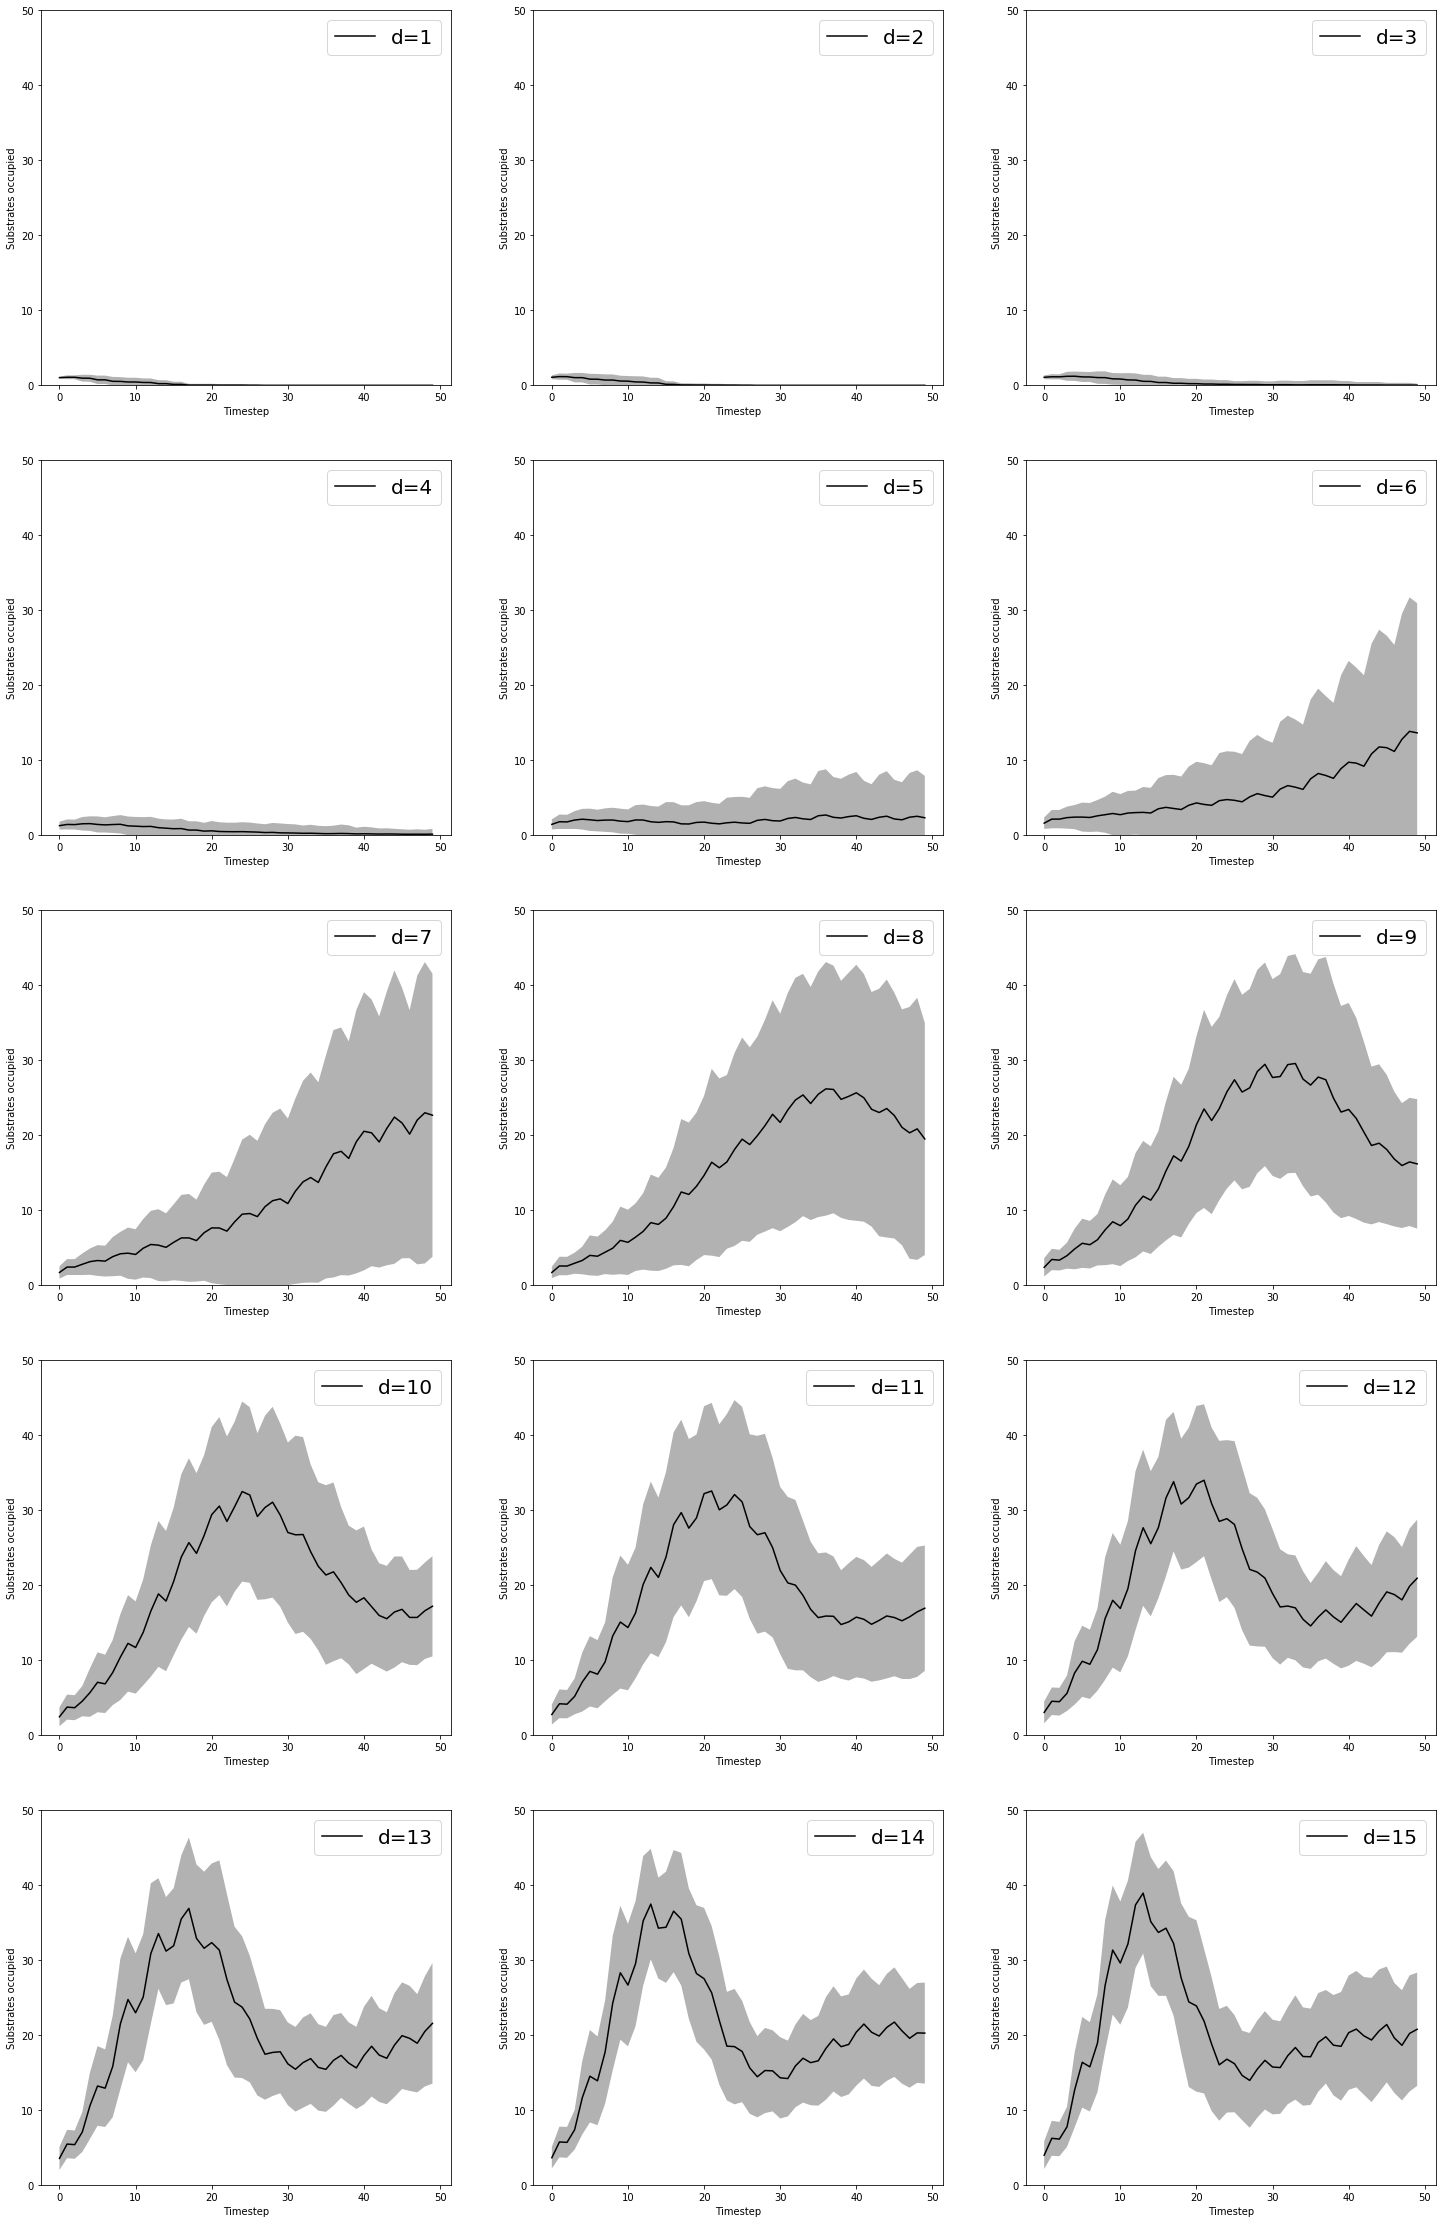

In [24]:
x = list(range(50))
fig, axes = plt.subplots(5,3, figsize=(25, 40)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,50) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            label=('d=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


Looks like it take at least a dispersal coefficient of <i>d=</i>8 to survive reliably on the default landscape conditions of the model, so we'll use this as an example of a "typical decomposer" for the purposes of our manuscript. But at <i>d</i>=8, it looks like much initial wood remains, so <i>d</i>=8 probably isn't an incredibly competitive dispersal coefficient. At <i>d</i>=10, the initial wood is consumed, and an equilibrium around the rate of wood deposit is achieved. There is little risk during the "lift-off" phase at <i>d</i>=10, in that even in the early steps of model runs there is little risk of extinction. So let's set this dispersal, <i>d</i>=10 as an example of an "aggressive decomposer" as used in our manuscripts. Interesting that at greater levels of dispersal it seems like there is an overshoot, where populations dip before recovering to a steady state. 

[back to contents](#contents)

<a id='initialwood'></a>

## Changing initial abundances of wood


We can hold the default non-viaphyic dispersal coefficient constant at <i>d</i>=8 and vary the initial abundance/energy of wood agents and wood-deposition rates. So first, what will it look like if we vary initial abundances of wood?

In [2]:
## aciss:
mpiexec -n 10 python3 runFA.py -sims 10 -ws 10 -numendo 0 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/initwood/ws10

In [27]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/initwood/initwood.p')

In [28]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

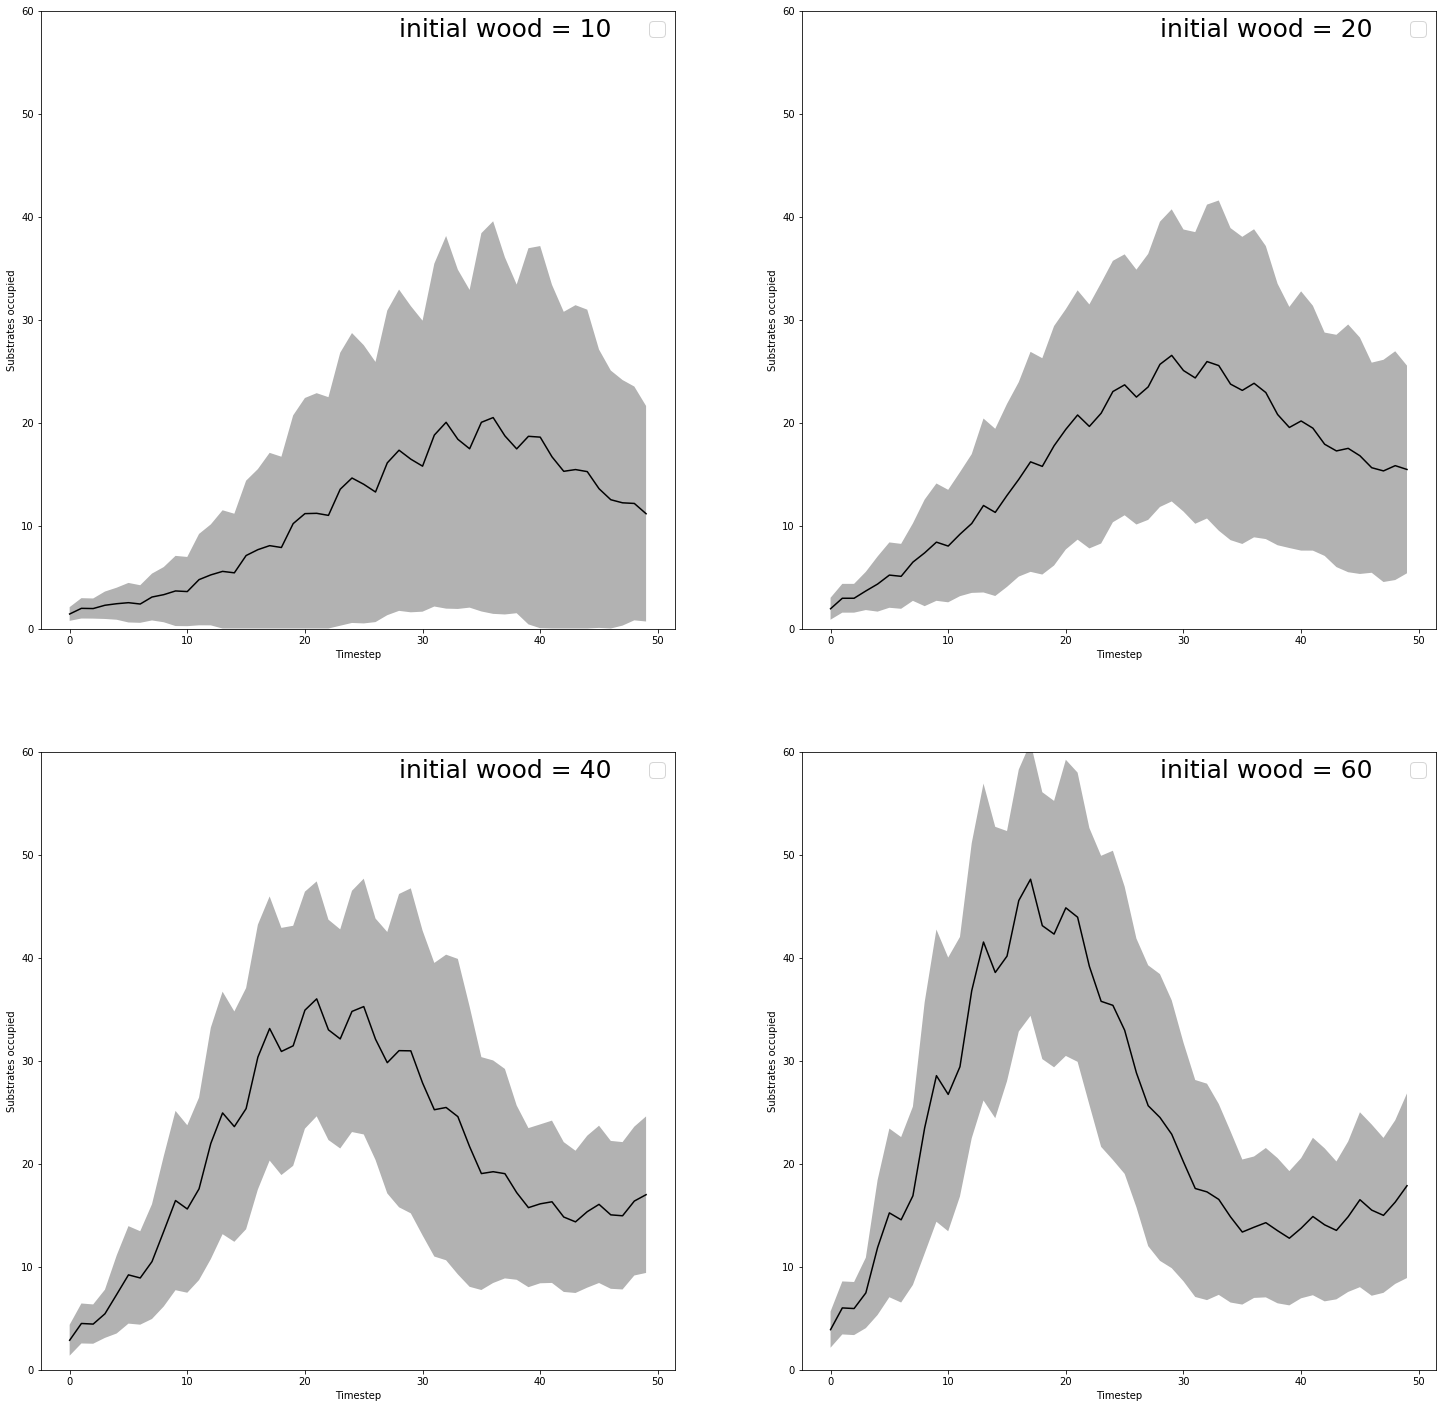

In [43]:
x = list(range(50))
fig, axes = plt.subplots(2,2, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,60) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            #label=('initial=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    z.text(0.90, 0.95, 'initial wood = %s' %lvls[i] +"0",
            verticalalignment='bottom', horizontalalignment='right',
            transform=z.transAxes,
            color='black', fontsize=25)
    
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


In general, if there is wood out there, a well-dispersed fungus will get it, then equilibriate to the steady state of wood as it falls.

[back to contents](#contents)

<a id='deposition'></a>
## Effect of wood deposition rates

Here we assume an initial amount of 30 energy in wood agents on the site, a medium-strong dispersing fungus (not endophyte-competent), and sweep over the rate of new wood deposition on the landscape. Note we aren't varying the frequency here of new wood agent deposition, this is kept the current model default of new wood every step (there is a parameter for this, can be changed, see [defaults](#setup)). Also note that the amount of energy in wood agents that being dropped over the landscape is being varied. Our model doesn't directly control the number of wood agents on the landscape - it allows user control of total energy stored in wood-agents to be modified. The number of new wood agents that act as containers of this energy every time step varies randomly (see ODD protocol description), but on average wood agent abundance is correlated closely with amount of energy. 

In [ ]:
## aciss
mpiexec -n 10 python3 runFA.py -sims 10 -newwood 2  -numendo 0 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/newwood/newwood2/

In [44]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/newwood/newwood.p')

In [45]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

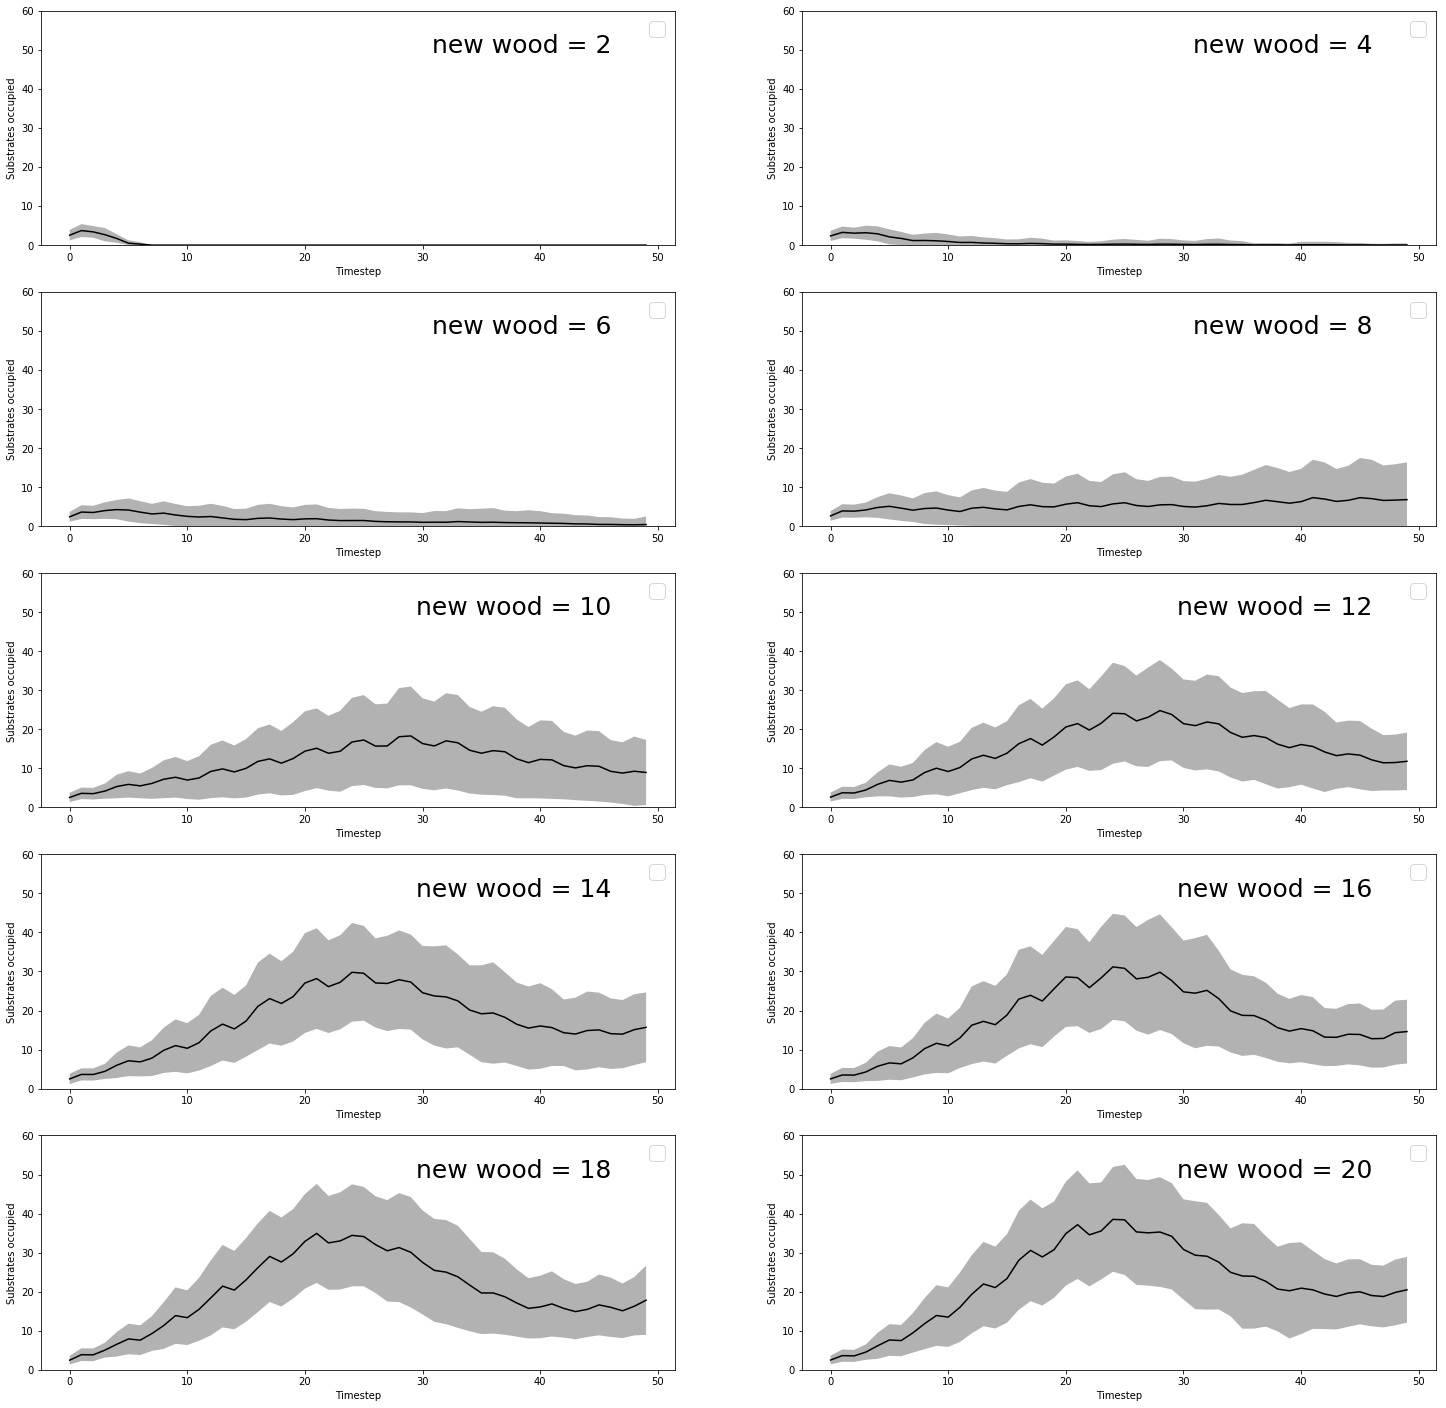

In [52]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,60) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            #label=('initial=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    z.text(0.90, 0.80, 'new wood = %s' %lvls[i],
            verticalalignment='bottom', horizontalalignment='right',
            transform=z.transAxes,
            color='black', fontsize=25)
    
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


It looks like with the forest and fungi we've built, a non-viaphytic fungus needs a regular supply of at least 12 or 14 in wood energy deposited each step to survive. With less than than this, we have some level of starvation.   Also interesting to note that there is an abundance of wood on these landscapes from initialization of the model, but that more even more wood is required to enable fungal populations to rise sharply to and consume these resources. This is presumably due to the need for new wood to bridge gaps to areas of plentiful uncolonized substrate. 

[back to contents](#contents)

<a id='basiccomp'></a>
## Basic competition experiments

Let's examine what happens when we compete two non-viaphytic fungi. We'll hold one species' dispersal ability constant at d=10, and vary the other's from 1 to 14. 

In [ ]:
## aciss
mpiexec -n 11 python3 runFA.py -no-endophytism -sims 10 -endodisp 1  -fileout /home6/dthomas/FA_ABM/sweeps/results/EC-EC-comp/disp1/disp1

In [27]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/EC-EC-comp/DDdisp.p')

In [28]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

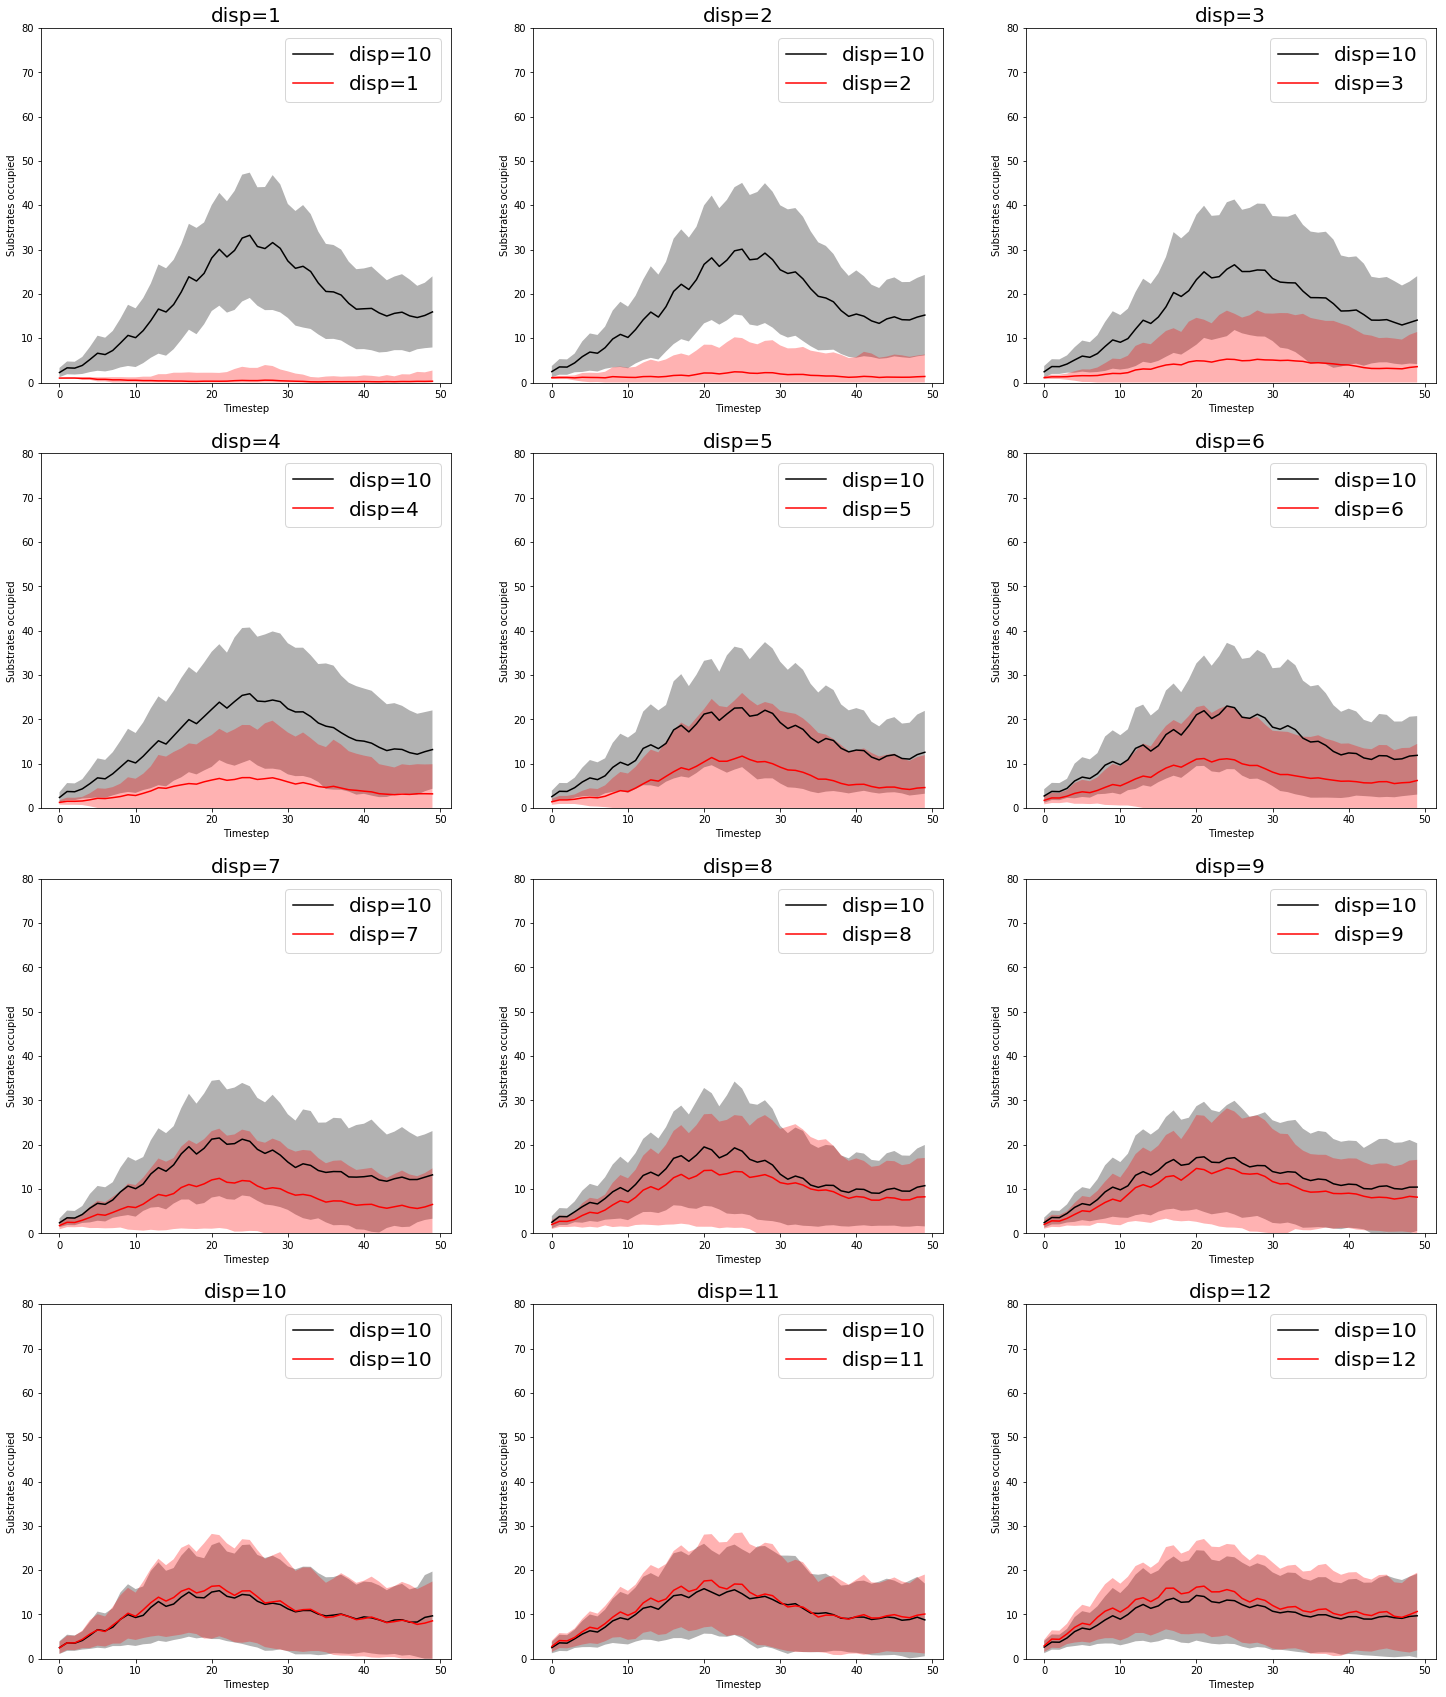

In [29]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    
    ## plot unchanging, default fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            label=('disp=10'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    
        ## plot fungus with changing disp:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='red',
            label=('disp=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('disp=%s' %lvls[i], {'fontsize':20})


Any fungal agent population with a dispersal coefficient <i>d</i> less that 8 just can't keep up. Conversely, when we ratchet our newcomer to <i>d</i>=11 or 12, both populations seem to suffer - both have a chance of going to zero. So there is a dispersal arms race here. For a competitor to persist on a landscape that contains aggressive fungal agents, the competitor must have dispersal abilities very close to their high rates and distance of spore dispersal. Or they must seek another strategy for dispersal...

[back to contents](#contents)

<a id='Endosurv'></a>
## Viaphyte survival

Let's see how viaphytes survive on the landscape, if we give leaves from trees a dispersal coefficient of 4 ([see notes on this](https://nbviewer.jupyter.org/github/danchurch/FA_ABM/blob/master/calibratingDispersal.ipynb#leafFall). As above we start with the model defaults. From here on, the sweeps are too expensive to be run serially, use mpi on aciss to handle them, even patches. 

So let's run a sweep of viaphytes dispersal coefficients, from 1 to 12. 

In [ ]:
mpiexec -n 11 python3 runFA.py -sims 10 -endodisp 1 -endophytism True -fileout '/home6/dthomas/FAsims/FA_ABM/sweeps/results/decomp_comp/disp1/disp1'

In [53]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endo_disp/endodisp.p')

In [54]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

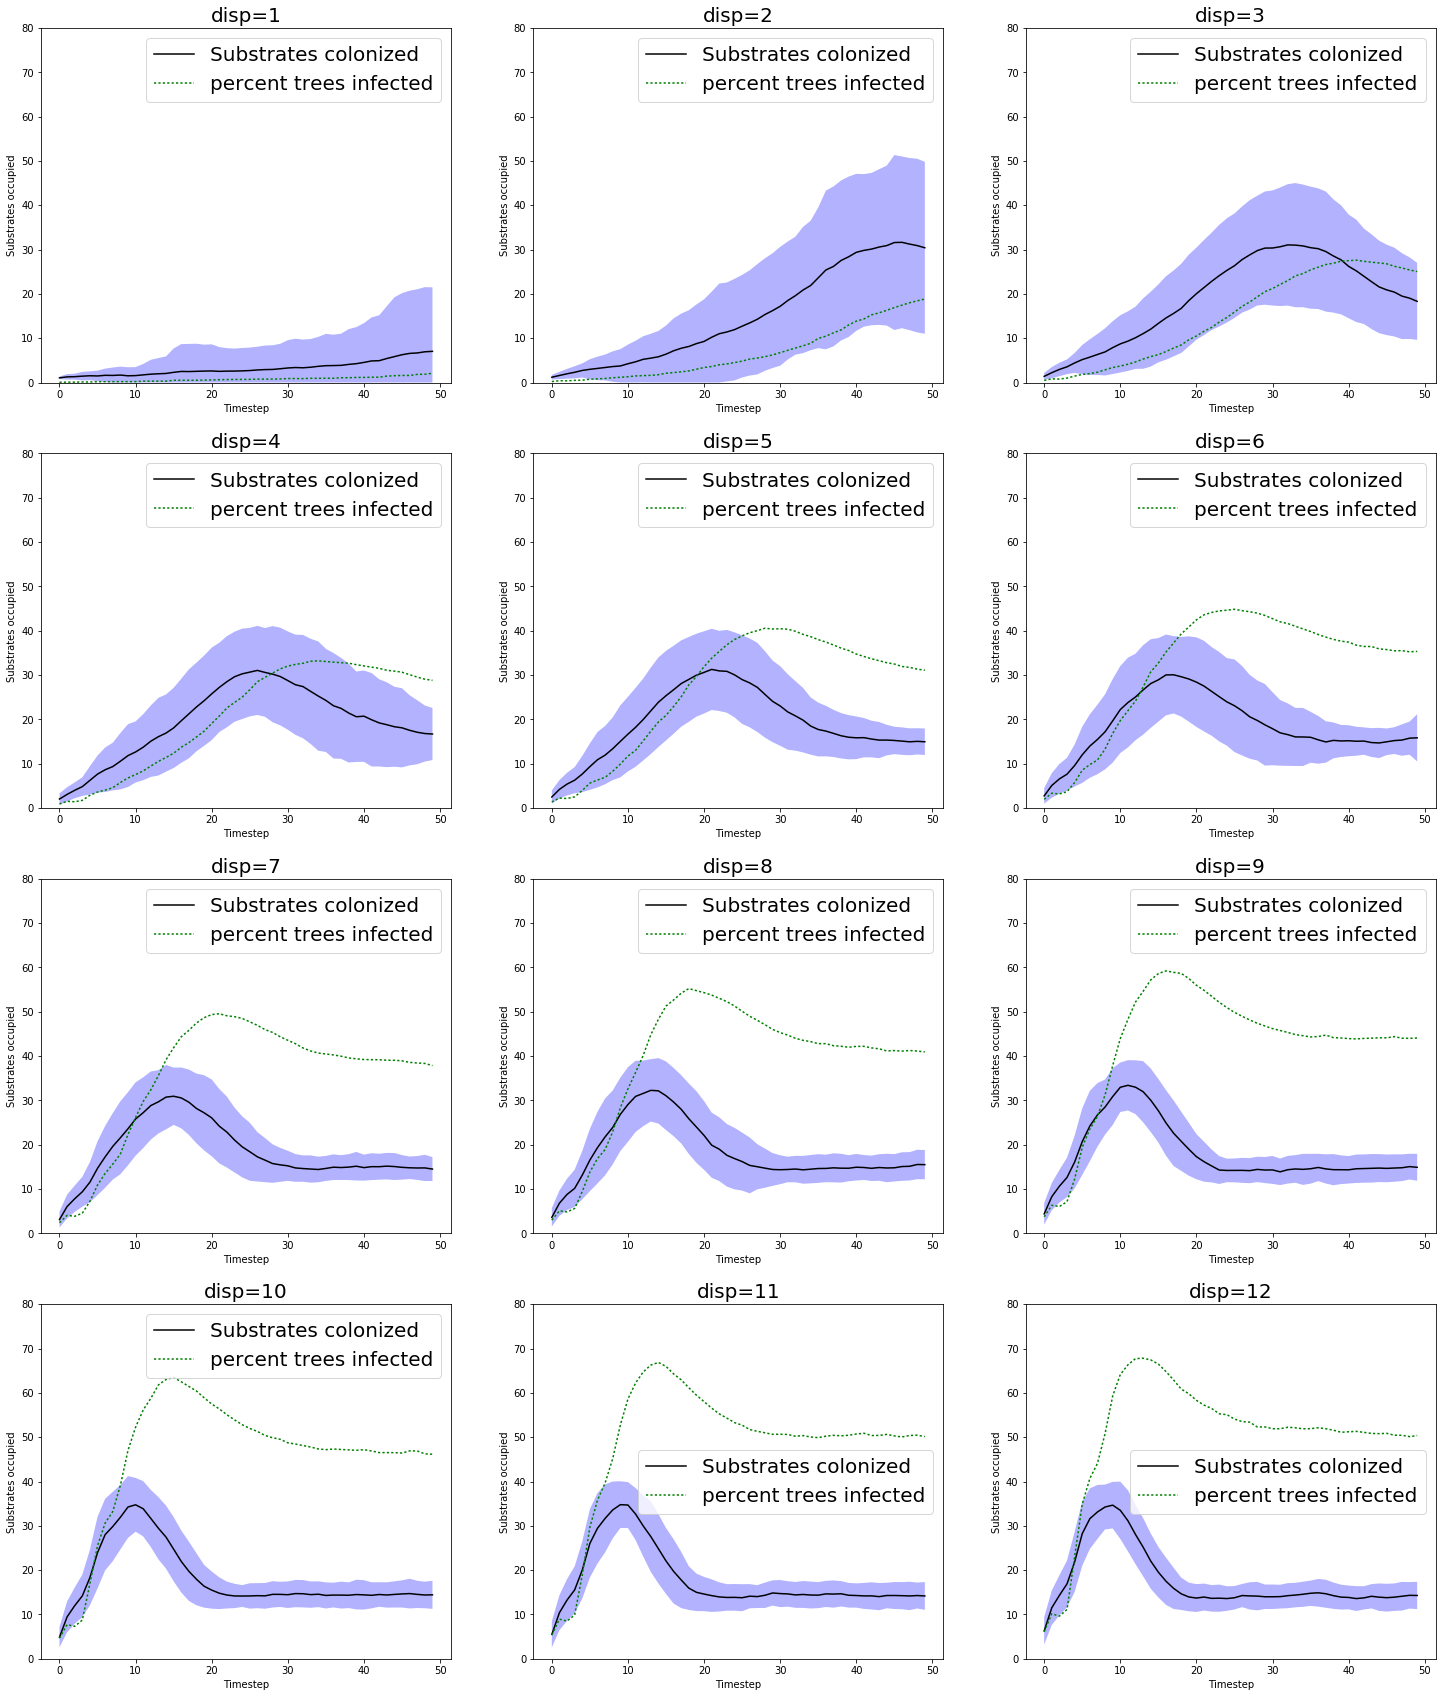

In [83]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='black',
            label=('Substrates colonized'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('disp=%s' %lvls[i], {'fontsize':20})


Even with a pretty low rate of endophyte loss (5% per step), the endophytes in the trees are affected by the amount of litter on the forest floor. 

Interesting. Under these, being an endophyte is useful quickly. Even fungus that can only disperse it's spores at disp=1 to persist on the landscape much of the time, in the dense forest scenario we are using. Notice also that even with the low default rate of endophyte loss (5% per step), the abundance of endophyte-stage fungi is sensitive to the patterns of woody debris on the forest floor.  

[back to contents](#contents)

<a id='endo_newwood'></a>

## Effect of wood deposition on viaphytes

Does having an endophytice phase in your lifestyle change your relationship to wood? Sweeping the rate of deposition of new wood on the landscape, with only viaphytic fungal agents present. 

In [ ]:
mpiexec -n 11 python3 runFA.py -numdecomp 0 newwood 2 -sims 10 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/endo_newwood/newwood10/newwood2

In [106]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endo_newwood/endo_newwood.p')

In [107]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

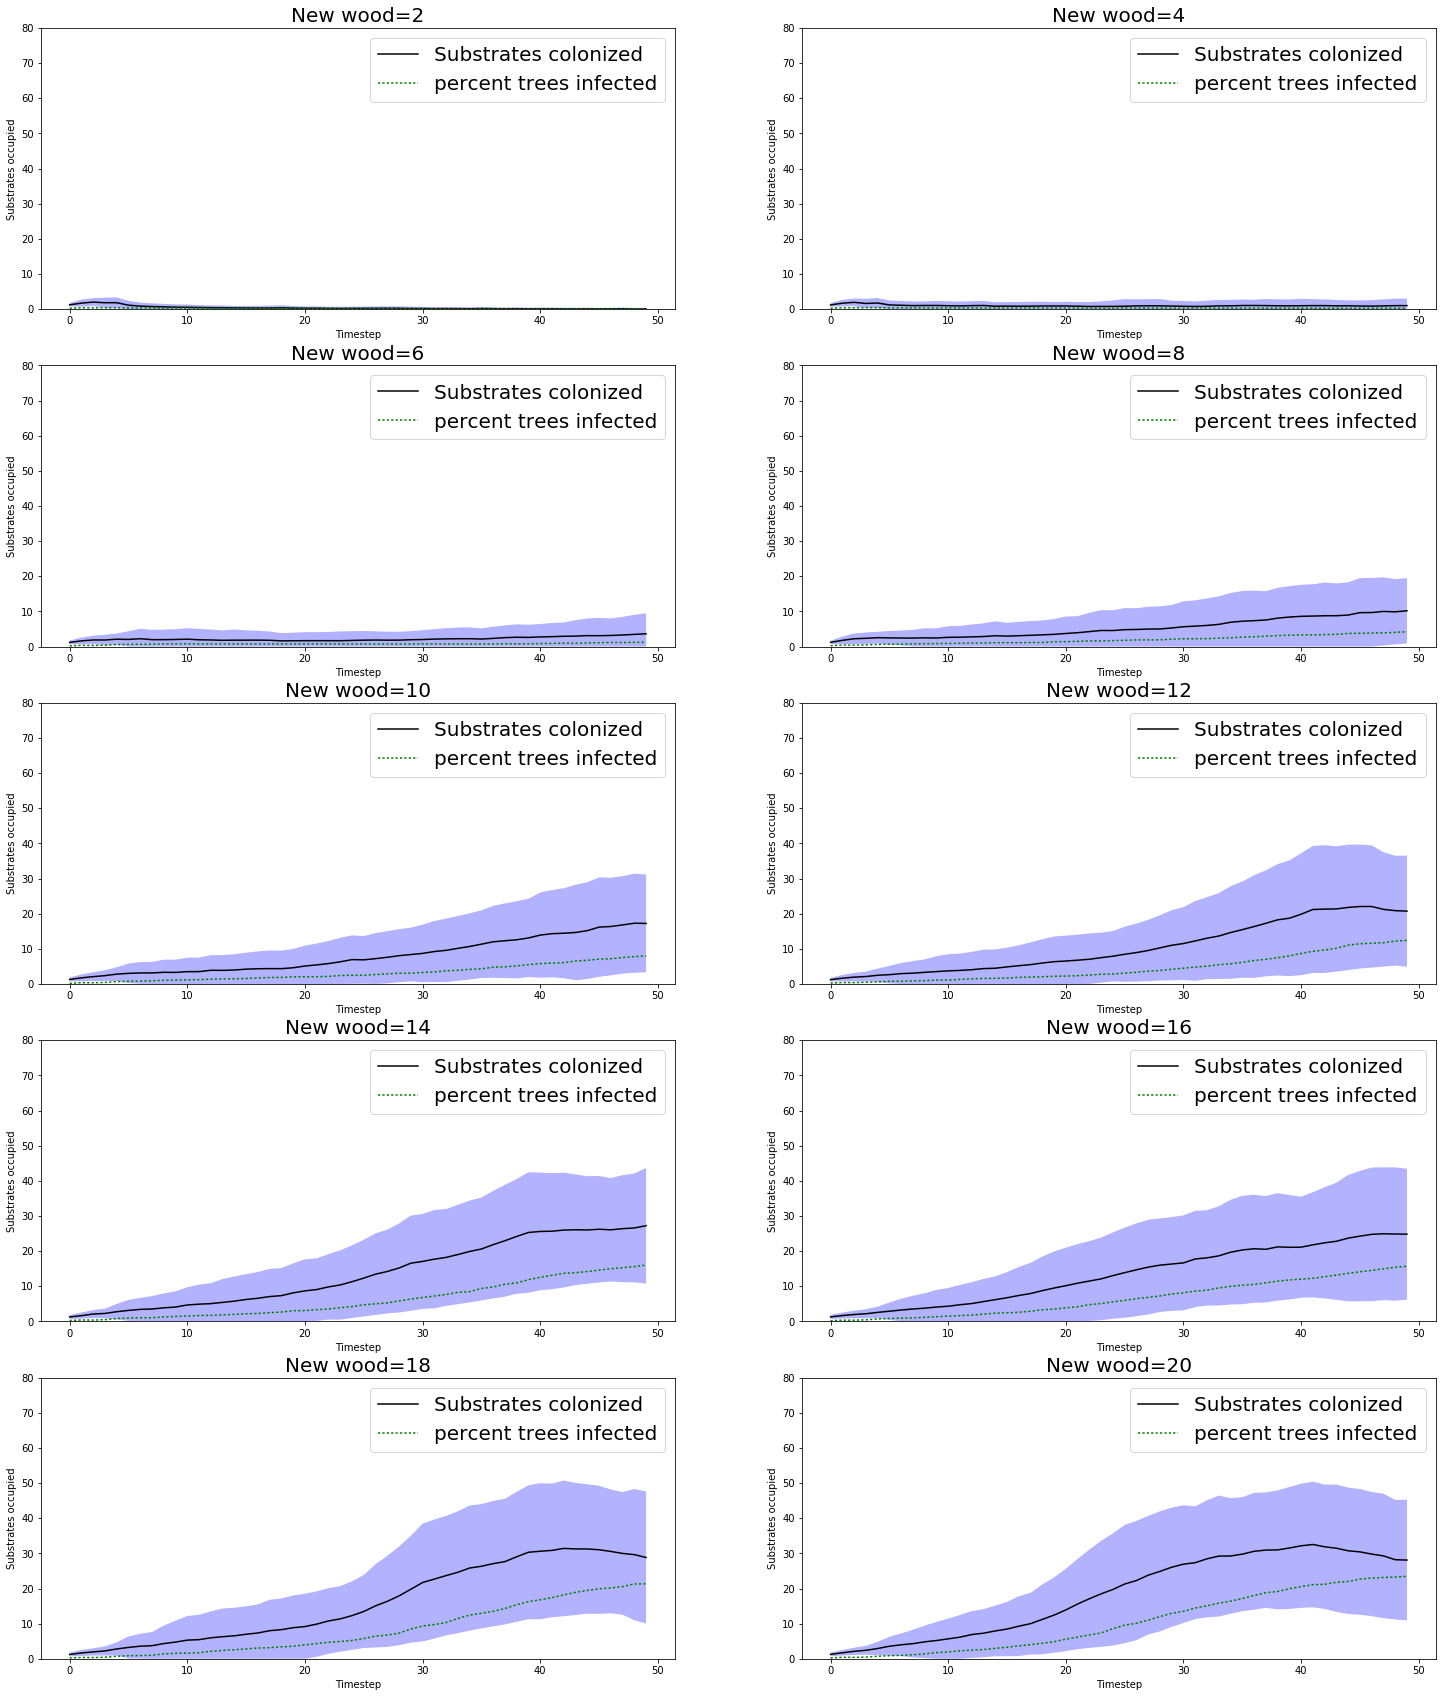

In [110]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='black',
            label=('Substrates colonized'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('New wood=%s' %lvls[i], {'fontsize':20})


[back to contents](#contents)

<a id='endocompetition'></a>

## Endophyte competition experiments

Now let's see if viaphytic fungi can compete against more aggressive, non-viaphytic fungi. In this sweep, we hold a non f-viaphytic fungal agent constant at the default <i>d</i>=10, and increment our viaphytic fungal agent from <i>d</i>=1 to <i>d</i>=12. The instructions to aciss for the first level (viaphyte <i>d</i>=1, non-viaphyte <i>d</i>=10) look like this: 

In [ ]:
mpiexec -n 10 python3 runFA.py -endodisp 1 -sims 10  -fileout ##...

In [117]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endodecomp_comp/endodecomp_comp.p')

In [118]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

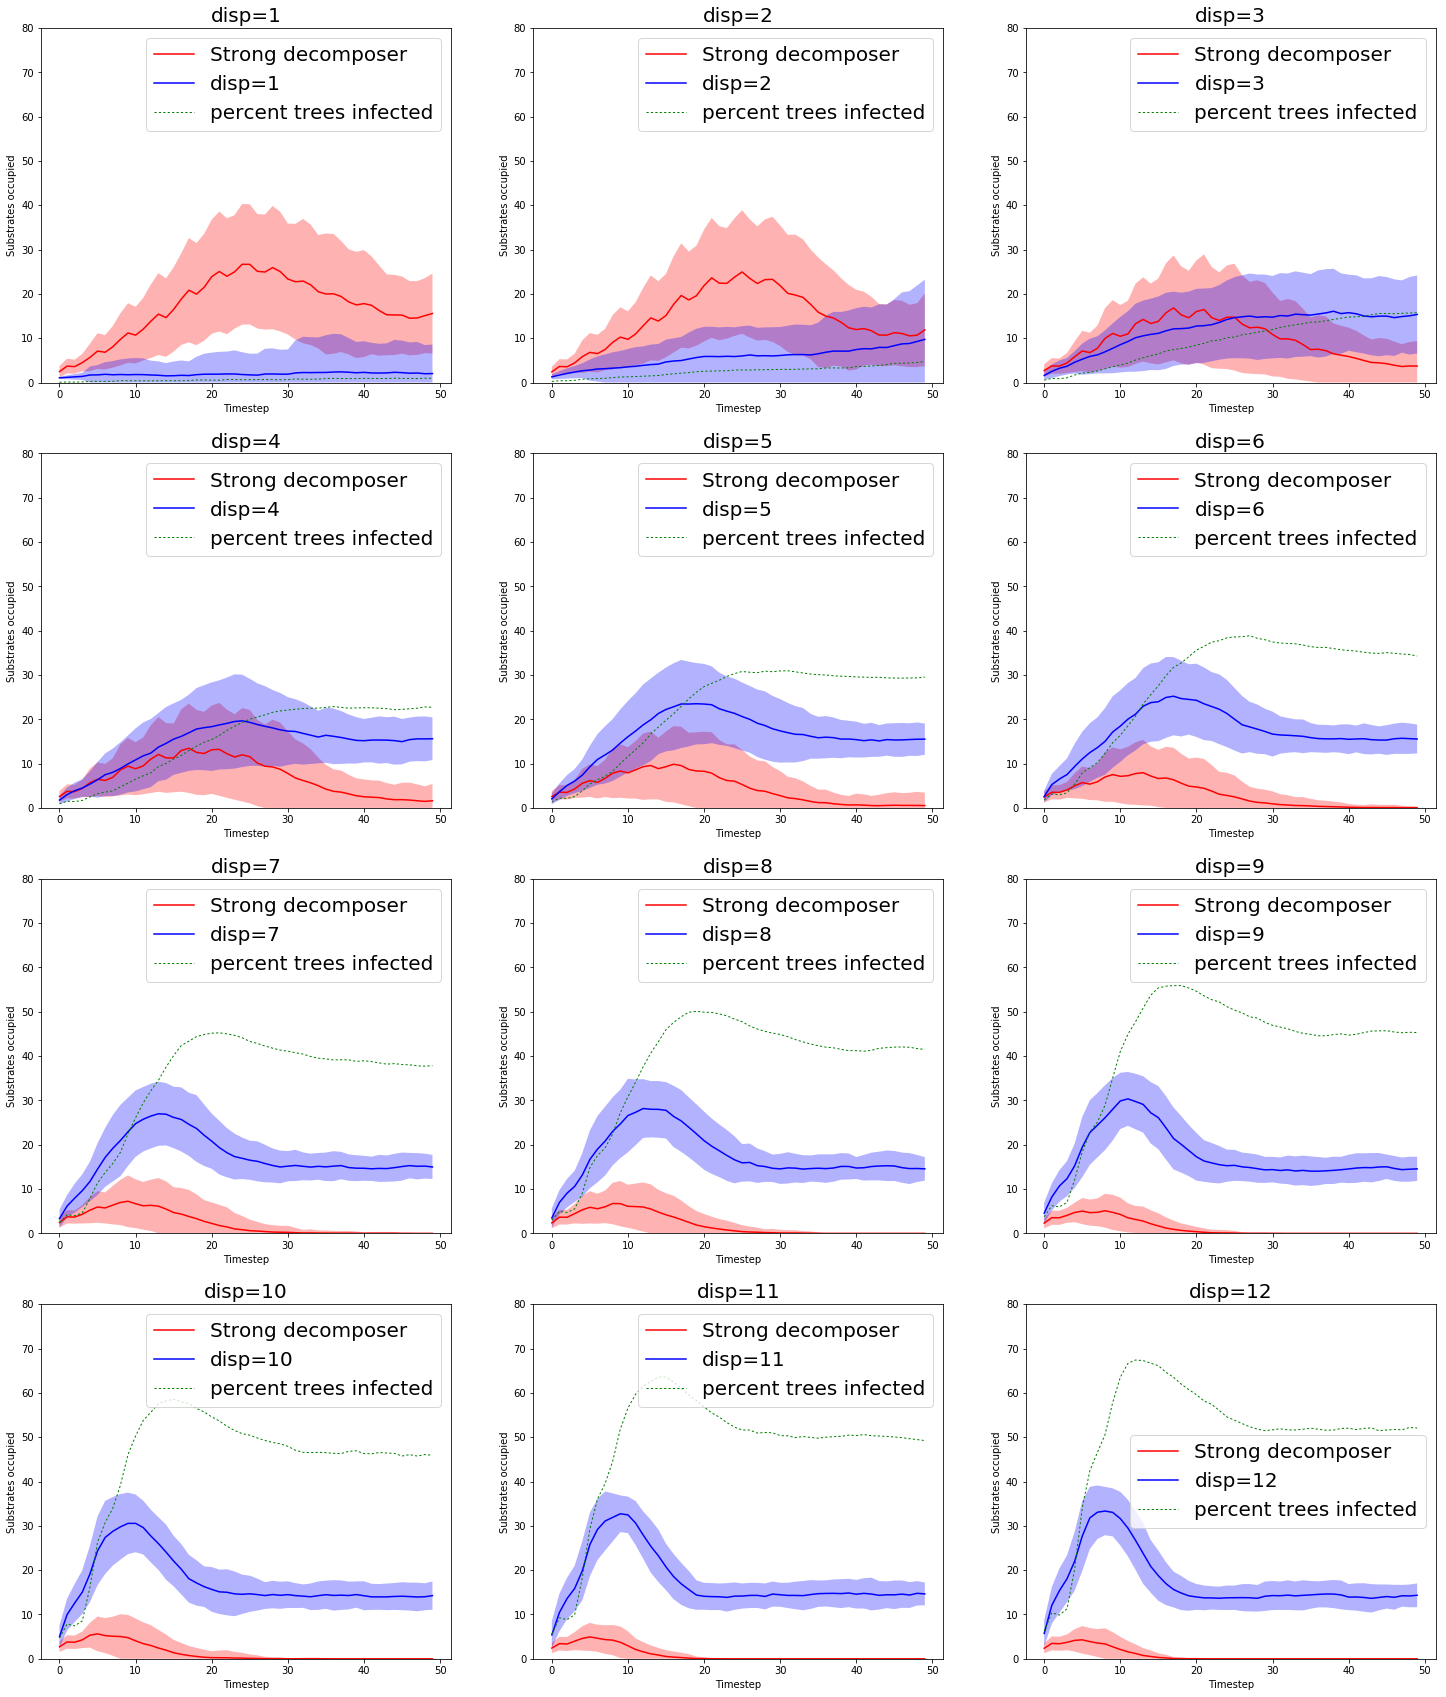

In [120]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('disp=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('disp=%s' %lvls[i], {'fontsize':20})


Under default settings, the endophytic lifestyle seems to be pretty beneficial. Even at viaphytic <i>d</i>=2 vs. non-viaphytic <i>d</i>=10, we have endophytes persisting on the landscape in some runs. At 3/8, viaphytism becomes a clear advantage, and beyond this the viaphyte species totally outcompetes the non-viaphyte. 

[back to contents](#contents)

<a id='endoloss'></a>
## Effect of endophyte loss

The residence time of endophytes in host trees isn't really understood and probably varies wildly with species of host and microbe. The defaults are set at endoloss=0.05, so that every infected tree has a 5% chance of losing it's infection. Our model defaults give viaphytes fungi a strong advantage at <i>d</i>=2, over default non-viaphytic fungi (<i>d</i>=10). But loss of endophyte infection by trees if fairly low in defaults, and we don't know how sensitive endophyte competitiveness is to the rate of endophyte loss. We'll increment the rate of endophyte loss from 0 to 90%. 

In [ ]:
#aciss
mpiexec -n 11 python3 runFA.py -sims 10 -endodisp 3 -endoloss 0   -endophytism True  -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/endoloss/endoloss0/endoloss0

In [124]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endoloss/endoloss.p')

In [125]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

In [126]:
lvls

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

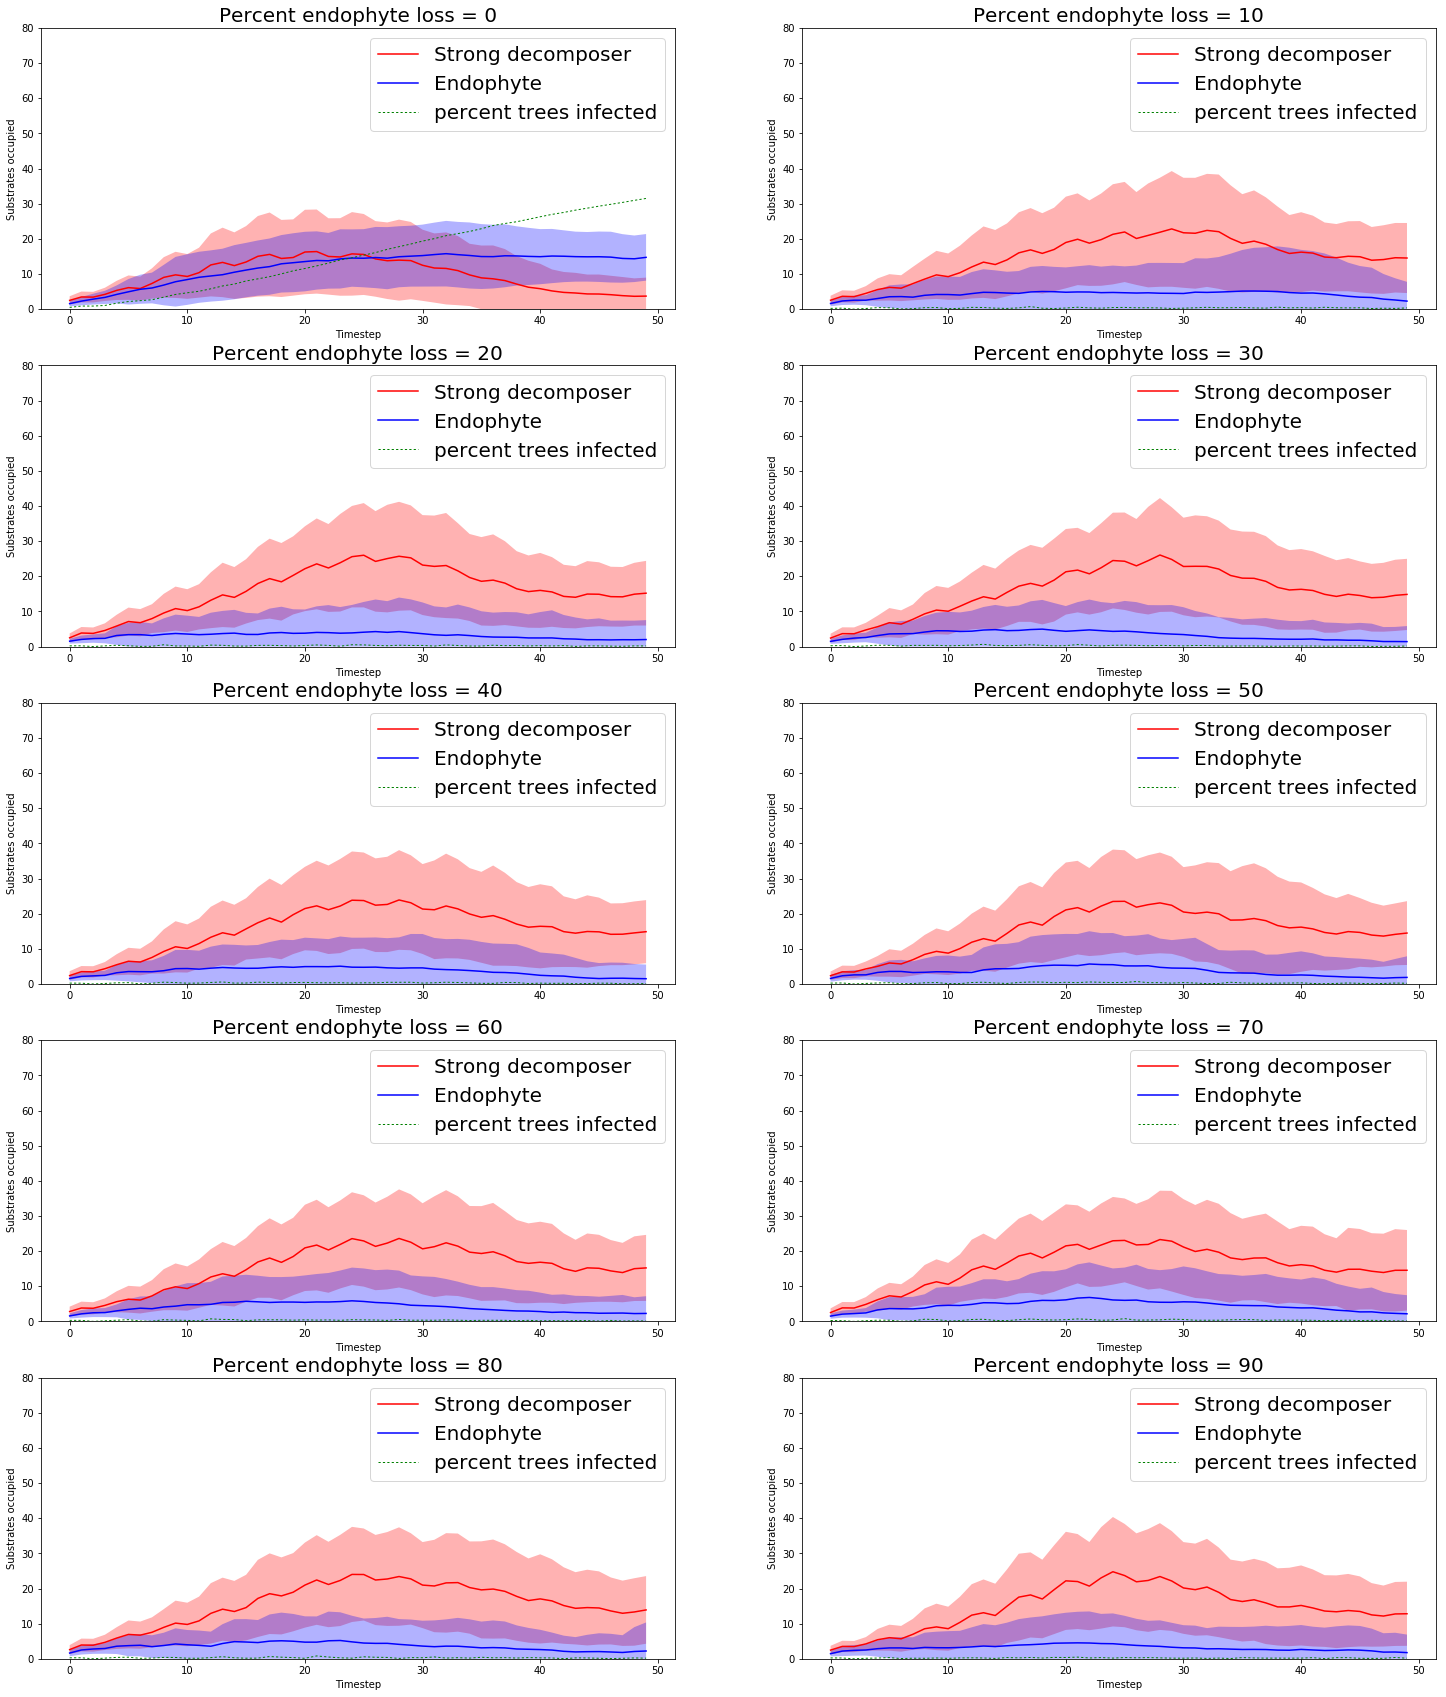

In [127]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('Endophyte'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('Percent endophyte loss = %s' %lvls[i], {'fontsize':20})


Okay, looks like this system is extremely sensitive to endophyte loss by trees. If endophytes are lost at ~10% or higher per step, it looks like the decomposer stage of the viaphyte fungal agent serves as the main propopagator, and endophytism is a little bit of a dead end. Less that, under otherwise default conditions, endophytism as a dispersal strategy rewards the fungus. 

[back to contents](#contents)

<a id='control'></a>
## 100-Step control run

Though I really wrote the model to handle short-term ecological simulations (~10-20 years), let's let it run this competition model little longer, and look at sporulation events, which are another way of measuring fitness besides number of substrates occupied. Will be useful for comparisons with deforestation runs.

In [73]:
control = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/thinonce/controldf.p')

In [74]:
runplotdata = pr.pldata_single(control,steps=100) ## use our single-level parser

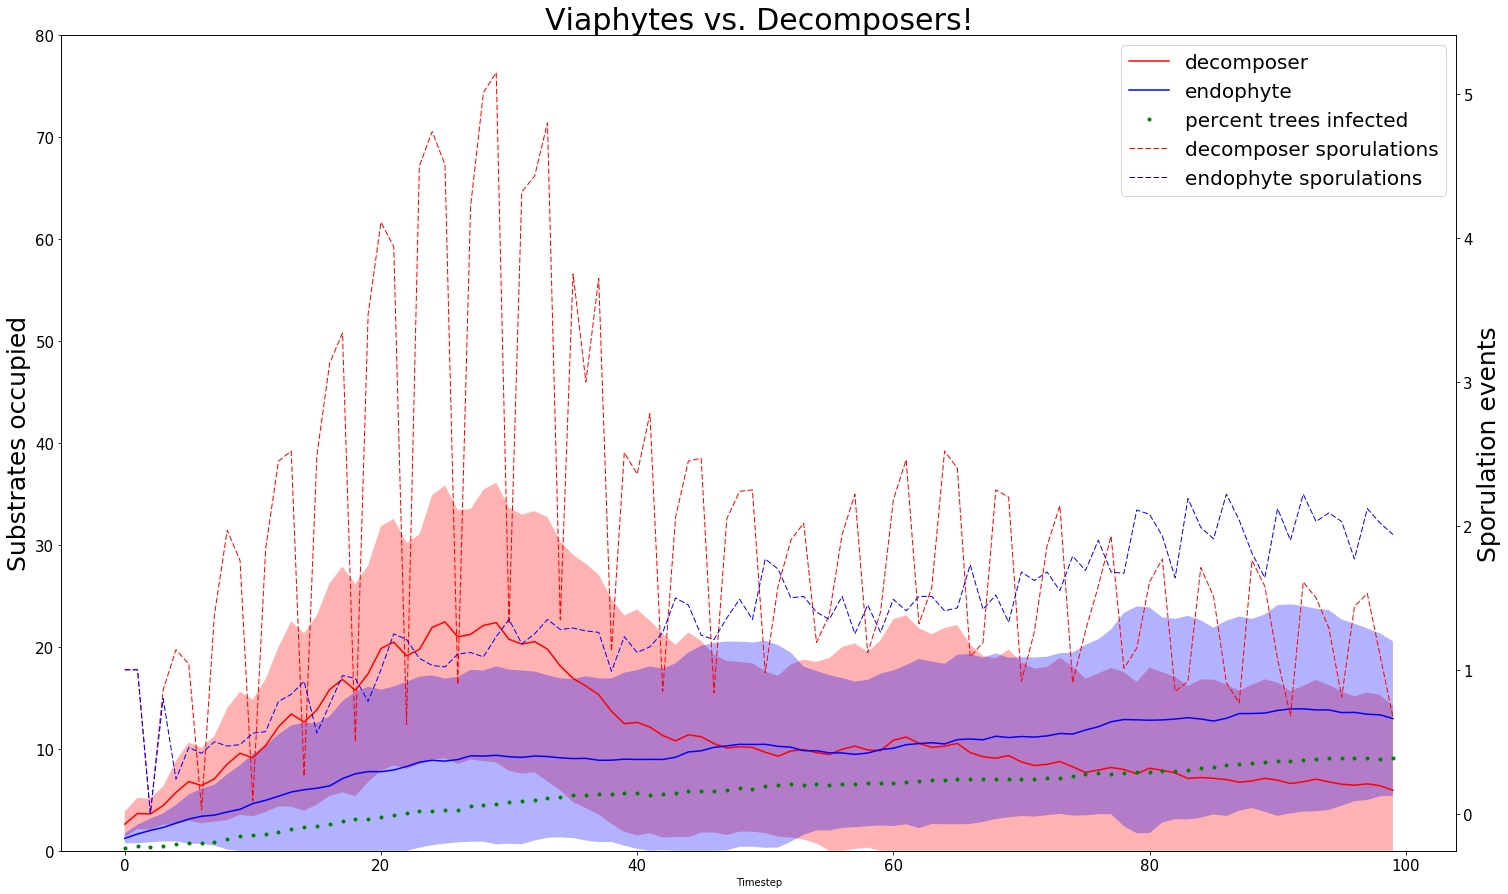

In [76]:
x = list(range(100))
fig = plt.figure(figsize=(25, 15))
z = fig.add_subplot(111)
z2 = z.twinx()
treepercent=[ (i/634)*100 for i in runplotdata['inf_trees_means'] ] ## convert mean trees to %
z.set_ylim(0,80) ## yaxis

## plot red fungus:
z.plot(x, runplotdata['decomp_means'],
        '-',
       c='red',
        label=('decomposer'),
        )
## error fill
z.fill_between(x, runplotdata['decomp_updev'],
                runplotdata['decomp_downdev'],
                linewidth=0,
                facecolor='red',
                alpha = 0.3,
                )
## plot blue fungus:
z.plot(x, runplotdata['endo_means'],
        '-',
       c='blue',
        label=('endophyte'),
        )

## error fill
z.fill_between(x, runplotdata['endo_updev'],
                runplotdata['endo_downdev'],
                linewidth=0,
                facecolor='blue',
                alpha = 0.3,
                )
## trees infected:
z.plot(x, treepercent,
        '.',
        linewidth=1,
        label=('percent trees infected'),
        c='green',
      )
## decomposer sporulations
z2.plot(x, runplotdata['despo_means'],
        '--',
        linewidth=1,
        label=('decomposer sporulations'),
        c='red',
        )
## endo sporulations
z2.plot(x, runplotdata['espo_means'],
        '--',
        linewidth=1,
        label=('endophyte sporulations'),
        c='blue',
        )

## combine legend info from both axes
aa=z.get_legend_handles_labels()
bb=z2.get_legend_handles_labels()
handles = aa[0] + bb[0]
labels = aa[1] + bb[1]

z.legend(handles, labels, prop={'size':20})
z.set_ylabel("Substrates occupied", {'fontsize':25})
z2.set_ylabel("Sporulation events", {'fontsize':25})
z.set_xlabel("Timestep")
z.set_title('Viaphytes vs. Decomposers!', {'fontsize':30})
z.tick_params(labelsize=15)
z2.tick_params(labelsize=15)


A less cluttered version here, for the manuscript.

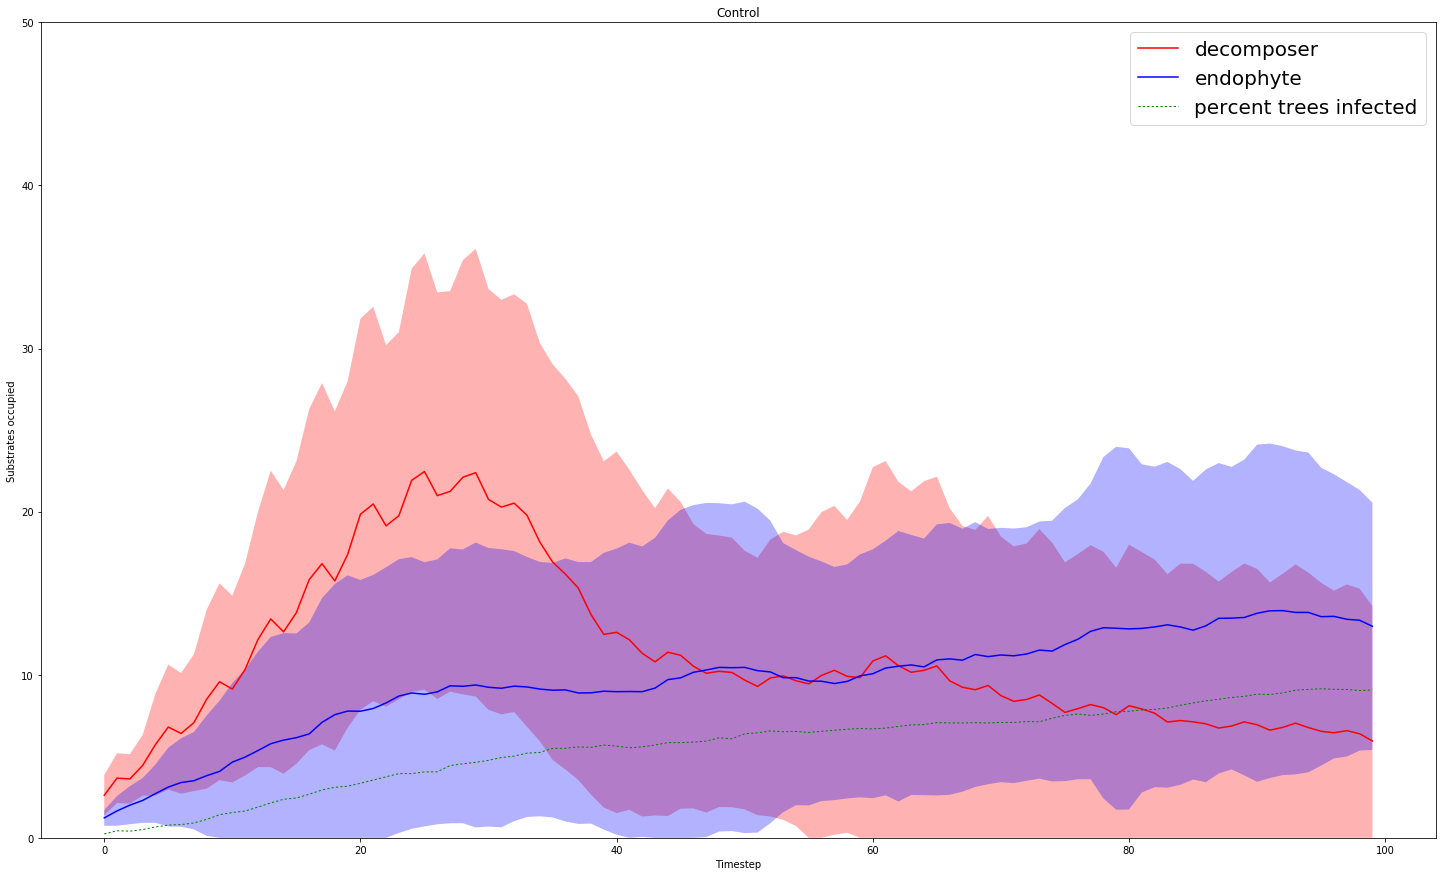

In [80]:
x = list(range(100))
fig = plt.figure(figsize=(25, 15))
z = fig.add_subplot(111)
treepercent=[ (i/634)*100 for i in runplotdata['inf_trees_means'] ] ## convert mean trees to %
z.set_ylim(0,50) ## yaxis

## plot red fungus:
z.plot(x, runplotdata['decomp_means'],
        '-',
       c='red',
        label=('decomposer'),
        )
## error fill
z.fill_between(x, runplotdata['decomp_updev'],
                runplotdata['decomp_downdev'],
                linewidth=0,
                facecolor='red',
                alpha = 0.3,
                )
## plot blue fungus:
z.plot(x, runplotdata['endo_means'],
        '-',
       c='blue',
        label=('endophyte'),
        )

## error fill
z.fill_between(x, runplotdata['endo_updev'],
                runplotdata['endo_downdev'],
                linewidth=0,
                facecolor='blue',
                alpha = 0.3,
                )
## trees infected:
z.plot(x, treepercent,
        ':',
        linewidth=1,
        label=('percent trees infected'),
        c='green',
      )

handles, labels = z.get_legend_handles_labels()
z.legend(handles, labels, prop={'size':20})
z.set_ylabel("Substrates occupied")
z.set_xlabel("Timestep")
z.set_title('Control')

plt.savefig('graphics/manuscript/control.svg')

[back to contents](#contents)

<a id='deforestation'></a>

# Deforestation 

We'll look at three scenarios of deforestation (see notes [here](https://github.com/danchurch/FA_ABM/blob/master/clustering.ipynb)). 

## Single thin event

The first is a general thin of trees across the landscape. We'll sweep across intensities of thinning, invoking a single thin event at step 51 of 100:

In [ ]:
mpiexec -n 10 python3 runFA.py -sims 10 -steps 100 -deforest_type thin -deforest_steps 51 -deforest_args .10  -fileout /home6/dthomas/FA_ABM/sweeps/results/thinonce/thinonce10/thinonce10 

In [35]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/thinonce/thinonce.p')

In [36]:
lvls = sorted(list(runs.keys()))[::-1] ########## reversed 
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i, 100) 

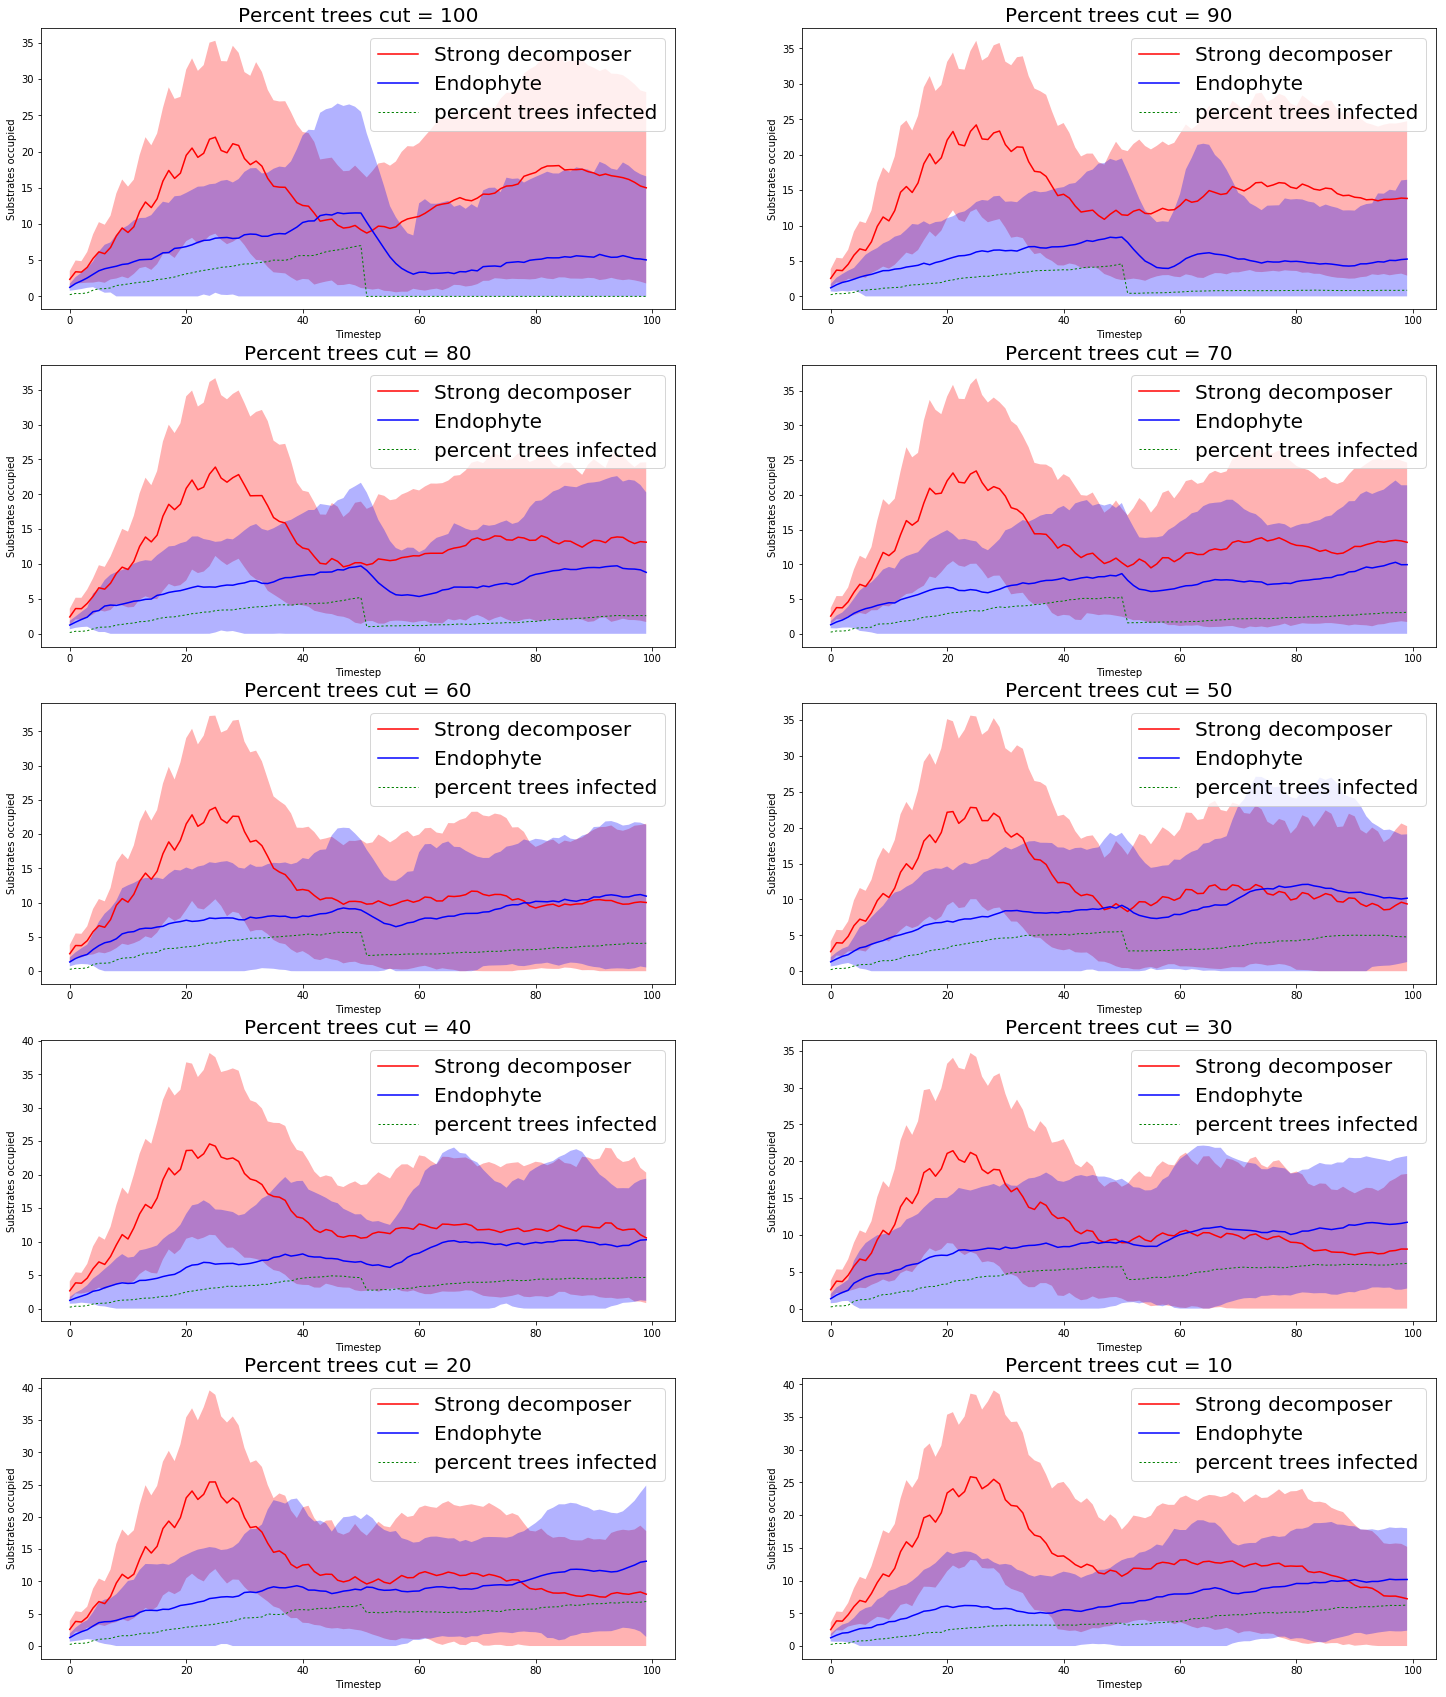

In [37]:
x = list(range(100))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    #z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('Endophyte'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('Percent trees cut = %s' %lvls[i], {'fontsize':20})


In this style of cut, endophytes seem to be able to sustain in up to perhaps a 70% reduction in canopy, even under fairly intense harvest. However, they don't prosper, persisting but not outcompeting viaphytes after reductions of tree agents larger than 30% or 40%.

[back to contents](#contents)

<a id='serialthin'></a>
## Serial thinning

Let's take a look at the effects of high-grading timber repeatedly, as often occurs in state forest reserves.

In [42]:
##aciss
mpiexec -n 10 python3 runFA.py -sims 10 -steps 100 -deforest_type thin -deforest_steps 51 61 71 81 91 -deforest_args .10 -fileout /home6/dthomas/FA_ABM/sweeps/results/serialthin

In [82]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/serialthin/serialthin.p')

In [83]:
runplotdata = pr.pldata_single(runs,100) ## use our single-level parser

In [84]:
runplotdata.keys()

dict_keys(['despo_downdev', 'decomp_means', 'espo_means', 'inf_trees_means', 'despo_means', 'espo_updev', 'endo_means', 'endo_downdev', 'inf_trees_downdev', 'decomp_updev', 'espo_downdev', 'inf_trees_updev', 'despo_updev', 'decomp_downdev', 'trees_means', 'endo_updev'])

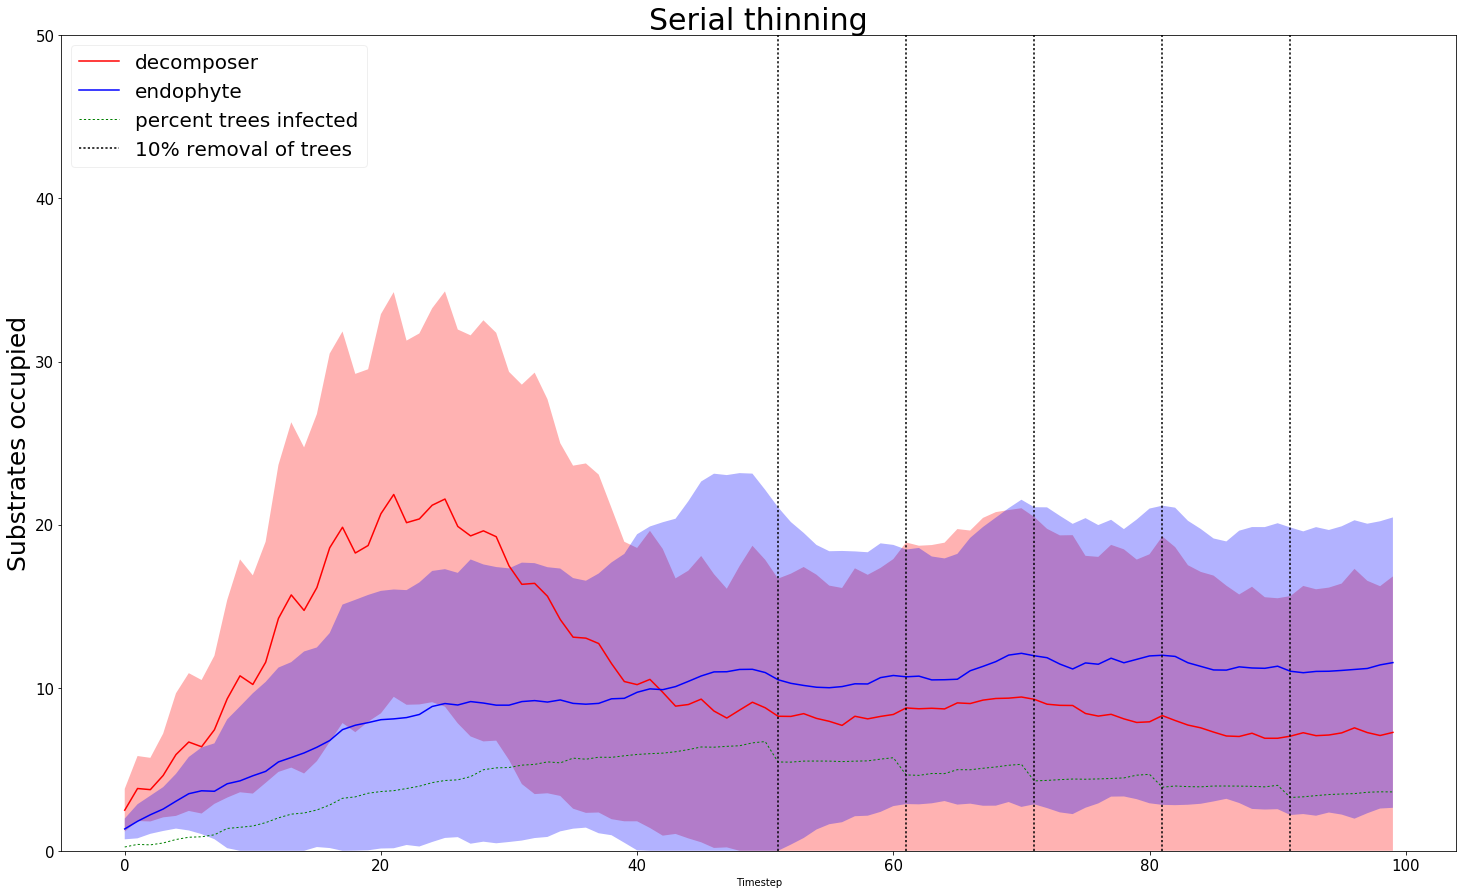

In [86]:
x = list(range(100))
fig = plt.figure(figsize=(25, 15))
z = fig.add_subplot(111)
inf_treepercent=[ (i/634)*100 for i in runplotdata['inf_trees_means'] ] ## convert infected trees to %
treepercent=[ (i/634)*100 for i in runplotdata['trees_means'] ] ## convert mean trees to %
z.set_ylim(0,50) ## yaxis
## plot red fungus:
z.plot(x, runplotdata['decomp_means'],
        '-',
       c='red',
        label=('decomposer'),
        )
## error fill
z.fill_between(x, runplotdata['decomp_updev'],
                runplotdata['decomp_downdev'],
                linewidth=0,
                facecolor='red',
                alpha = 0.3,
                )
## plot blue fungus:
z.plot(x, runplotdata['endo_means'],
        '-',
       c='blue',
        label=('endophyte'),
        )

## error fill
z.fill_between(x, runplotdata['endo_updev'],
                runplotdata['endo_downdev'],
                linewidth=0,
                facecolor='blue',
                alpha = 0.3,
                )
## trees infected:
z.plot(x, inf_treepercent,
        ':',
        linewidth=1,
        label=('percent trees infected'),
        c='green',
      )


## show times of tree removal with vertical bars

z.plot((51,51),(0,50),":", c='black')
z.plot((61,61),(0,50),":", c='black')
z.plot((71,71),(0,50),":", c='black')
z.plot((81,81),(0,50),":", c='black')
z.plot((91,91),(0,50),":", c='black', label="10% removal of trees")

handles, labels = z.get_legend_handles_labels()
z.legend(handles, labels, prop={'size':20}, framealpha=0.3)
z.set_ylabel("Substrates occupied", {'fontsize':25})
z2.set_ylabel("Sporulation events", {'fontsize':25})
z.set_xlabel("Timestep")
z.set_title("Serial thinning", {'fontsize':30})
z.tick_params(labelsize=15)
z2.tick_params(labelsize=15)

plt.savefig('graphics/manuscript//serialthin.svg')

Ultimately, this amounts to ~40% reduction in trees over time. Looks like a well established endophyte population can handle this kind of "gradual" thin better than the equivalent sudden reduction of all 70% at once. 

Seems like this could only work if endophytes were well established on the landscape. What we've done here is let a poorly dispersing fungus get a leg up on its competitor for a decade through other means (viaphytism), and once dominance on the landscape is established, removed the crutch. 

[back to contents](#contents)

<a id='fragment'></a>
## Forest fragmentation

Let's take a look at the effects of removing large contiguous areas of forest, as often occurs in with land use conversions to agriculture, extraction, homesteading, etc.

In [ ]:
## aciss
mpiexec -n 10 python3 runFA.py -sims 10 -steps 100 -deforest_type fragment -deforest_steps 51 -deforest_args 3  15  -fileout /home6/dthomas/FA_ABM/sweeps/results/frag15/frag3/frag3

In [30]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/frag15/frag_rad15.p')

In [31]:
lvls = sorted(list(runs.keys())) ## lvls of the run, sorted
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i, 100) 

In [32]:
lvls

[3, 4, 7, 9, 12, 15, 20, 27, 35, 45]

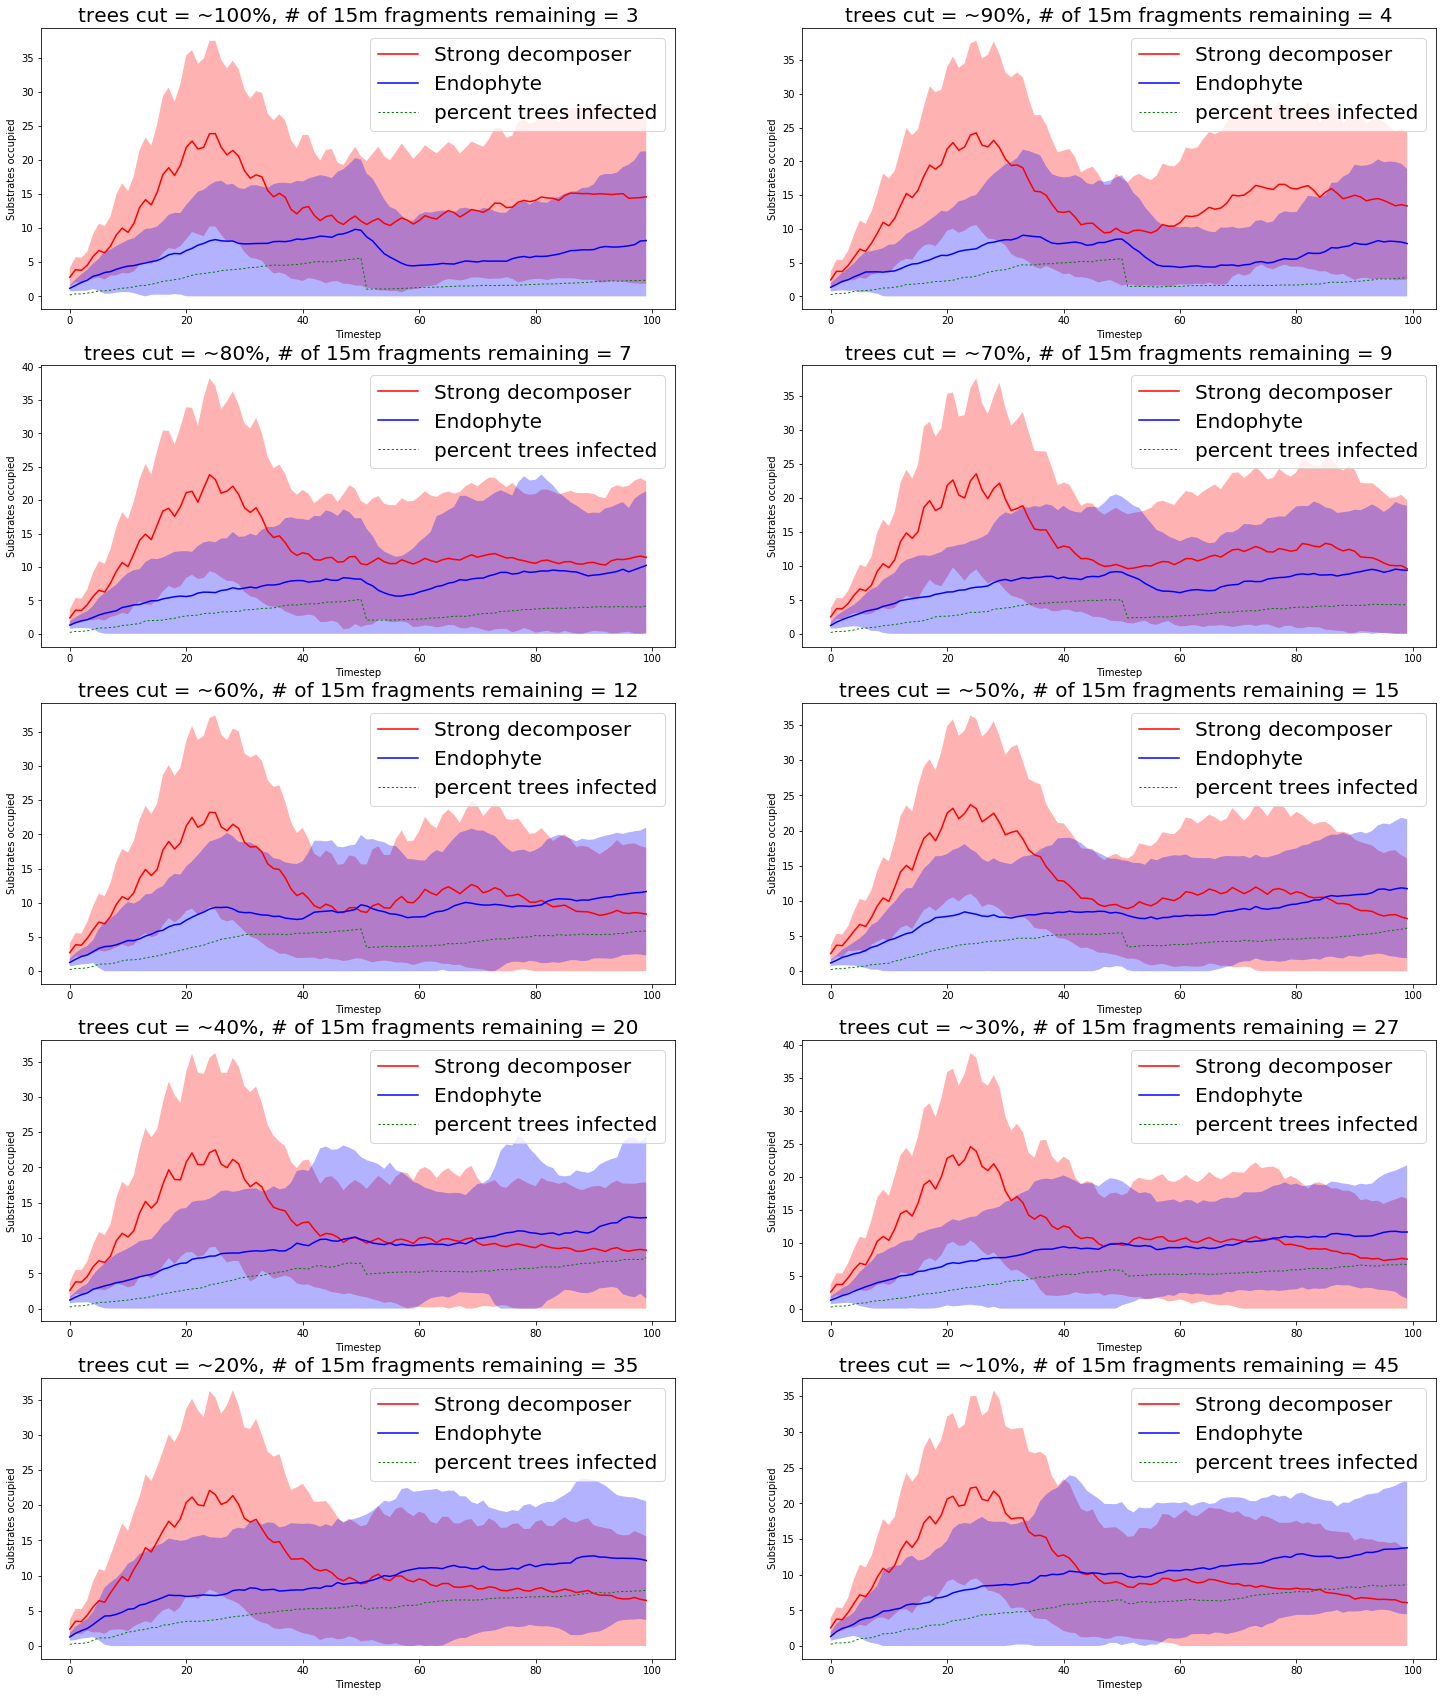

In [34]:
x = list(range(100))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    #z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('Endophyte'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    perc = [10,20,30,40,50,60,70,80,90,100][::-1]
    z.set_title('trees cut = ~%s%%, # of 15m fragments remaining = %s' %(perc[i],lvls[i]), {'fontsize':20})


Similar to thinning results above, in that viaphytes can often persist even through a 60%-70% loss of tree agents. The main difference seems to be that viaphytes do a little better, not just persisting, but also retaining a competitive advantage up to 60% loss. 

[back to contents](#contents)